#### OPENCLASSROOMS - Parcours Data Scientist  
## Projet 7: Implémentez un modèle de scoring  
Etudiant: Eric Wendling  
Mentor: Julien Heiduk  
Date: 17/09/2020

**TABLE DES MATIERES**

#### [Introduction](#int)

#### [Partie 2 - Modelisation Machine Learning](#mod_mac_lea)

#### [Initialisation](#ini)
 
+ [Import des modules Python](#imp_mod_pyt)
+ [Fonctions](#fon)
 + [Description des variables](#des_var)
+ [Paramètres d'initialisation](#par_ini)

#### [Préparation des données](#pre_don)

+ [Récupération des données](#rec_don)
+ [Echantillonnage des données](#ech_don)
+ [Seuil de variance](#seu_var)
+ [Jeux d'entraînement et de test](#jeu_ent_tes)
+ [Modélisation du traitement des données](#mod_tra_don)
+ [Traitement des données](#tra_don)
+ [Dimensions des jeux d'entraînement et de test](#dim_jeu_ent_tes)

#### [Machine Learning](#mac_lea)

+ [Modélisation](#mod)
+ [Classifieurs](#cla)
 + [Logistic Regression](#log_reg)
 + [Random Forest](#ran_for)
 + [XGBoost](#xgb)
 + [CatBoost](#cat)
 + [LightGBM](#lgb)
+ [Entraînement des classifieurs](#ent_cla)

#### [Réduction de dimension](#red_dim)

+ [Variables les plus importantes](#var_plu_imp)
+ [Recursive feature elimination (RFE)](#rec_fea_eli)
+ [Modèle de sélection de variables](#mod_sel_var)

#### [Entraînement LightGBM (après réduction des variables)](#ent_lgb_apr_red_var)

#### [Optimisation des paramètres avec Hyperopt](#opt_par_hyp)

+ [Fonction d'évaluation du gain](#fon_eva_gai)
+ [Modélisation Hyperopt](#mod_hyp)

#### [Entraînement LightGBM optimisé](#ent_lgb_opt)

+ [Paramètres optimisés](#par_opt)
+ [LightGBM optimisé (auc_score)](#lgb_opt_auc)
+ [LightGBM optimisé (f1_score)](#lgb_opt_f1s)
+ [LightGBM optimisé (gain)](#lgb_opt_gai)
+ [Tableau comparatif des scores](#tab_com_sco)
+ [Evolution du gain](#evo_gai)
+ [Evolution des indicateurs ROC](#evo_ind_roc)

#### [Importance des variables](#imp_var_2)

#### [Classification report](#cla_rep)

#### [Jeu de test sans étiquette](#jeu_tes_san_eti)

#### [Interprétation](#int_2)

+ [Interprétation avec LIME](#int_lim)
+ [Interprétation avec SHAP](#int_sha)

#### [Application Dash](#app_das)

+ [Similarité](#sim)
+ [Sérialisation pour l'application Dash](#ser_app_das)

#### [Synthèse et conclusion](#syn_con)

## Introduction <a class="anchor" id="int"></a>

Le projet concerne la réalisation d'une application de **Crédit Scoring** basée sur des technologies de **Machine Learning**. L'analyse et le traitement des données ont déjà été réalisés dans le notebook https://github.com/leerik/OC_DS_P7/blob/master/P7_01_analyse.ipynb.

Le présent notebook est dédié à la modélisation. Le modèle sera *in fine* déployé via une application web développée avec la technologie `Dash`. Le code de l'application est inscrit dans le notebook https://github.com/leerik/OC_DS_P7/blob/master/P7_03_dashboard.ipynb, l'application est déployée ici: https://credit-scoring-dashboard.herokuapp.com/.

## Partie 2: Modelisation Machine Learning <a class="anchor" id="mod_mac_lea"></a>

Les objectifs de la modélisation sont les suivants:

+ Le modèle doit permettre de définir la ***probabilité de défaut de remboursement*** d'un crédit sur la base d'informations relatives au client.
+ Il doit également offrir un certain niveau de transparence concernant les données et leurs traitements en vue d'implémenter des méthodes d'***interprétabilité*** des variables.

La démarche suit les principales étapes suivantes:

**1) Type de modèle**

Le résultat attendu le plus important pour un dossier est la valeur de la probabilité de non-paiement. En appliquant un seuil à cette valeur, nous pouvons lui affecter une valeur binaire (0 ou 1) suivant que la probabilité est inférieure ou supérieure au seuil.

+ Si la probabilité est inférieure au seuil, on considère que le crédit sera remboursé, le dossier est négatif (0).
+ Si le probabilité est supérieure au seuil, on considère que le crédit ne sera pas remboursé, le dossier est positif (1).

>Il s'agit donc d'un problème de **classification** dont le résultat binaire dépend du paramètre **seuil de classification**.

**2) Métriques**

Pour évaluer le modèle on compare les valeurs prédites avec les valeurs réelles. On peut ainsi établir un tableau indiquant le nombre de valeurs correctement prédites ou non (matrice de confusion).

Les valeurs de la matrice de confusion peuvent être traduites en des indicateurs caractérisant le modèle, dont les plus importants sont la **sensibilité** et la **spécificité** dont les évolutions peuvent être représentées en fonction du **seuil de classification** avec une **courbe ROC**.
>La mesure de l'aire sous la courbe (**AUC**) traduit la performance du modèle et représente à ce titre la métrique utilisée pour évaluer les différents modèles.

**3) Classifieurs**

Nous allons tester plusieurs modèles de classifieurs basés sur les **arbres de décision**.
>Ces derniers sont bien adaptés à la résolution de problèmes de classification binaire et offrent des méthodes d'identification de l'importance des variables utiles à l'interprétation des processus de décision.

**4) Optimisation technique**

Suite à l'étape 3, nous retiendrons un modèle de classifieur que nous allons optimiser d'abord par ***réduction de variables*** puis par ***ajustement des hyper-paramètres***.

**5) Optimisation métier**

Les résultats obtenus après les optimisations techniques ne répondent pas nécessairement aux performances métier. Concernant l'octroi de crédits, l'organisme financier cherchera d'abord à optimiser son chiffre d'affaire. On comprend dès lors que les dossiers de crédits non remboursés représentent des pertes importantes.

>Il s'agira alors d'ajuster le modèle afin de minimiser les risques d'octroi de crédit pour des clients finalement non solvables.

**6) Déploiement**

Finalement, le modèle optimisé sera mis à disposition des utilisateurs via une application web.

## Initialisation <a class="anchor" id="ini"></a>

### Import des modules Python <a class="anchor" id="imp_mod_pyt"></a>

In [1]:
import sys   
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
print('Python',sys.version)
from sys import exit

import pandas as pd
print('Pandas',pd.__version__)
pd.options.mode.chained_assignment = None

import numpy as np
print('Numpy',np.__version__)

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
print('Matplotlib',matplotlib.__version__)

import seaborn as sns
sns.set(style="darkgrid")
print('Seaborn',sns.__version__)

from IPython.display import Image, HTML
from wordcloud import WordCloud, STOPWORDS

from IPython.display import Image, HTML
from sklearn.metrics.pairwise import linear_kernel

import tqdm
import time
from time import strftime, gmtime
from pprint import pprint
import squarify
import random
from IPython.display import Markdown

import pickle
import joblib
from joblib import dump, load

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import gc

Python 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
Pandas 1.0.3
Numpy 1.18.3
Matplotlib 3.2.1
Seaborn 0.10.1


### Fonctions <a class="anchor" id="fon"></a>

#### Description des variables <a class="anchor" id="des_var"></a>

Les descriptions des principales variables originales sont fournies dans un fichier qui a été traité dans la partie 1 (P7_01_analyse).

La fonction **col_desc()** permet d'interroger ce dataframe avec 2 critères: le nom de la table et le nom de la variable (avec troncature).

In [2]:
df_var = joblib.load('../OC_DS_P7/features_desc/df_var.joblib')

def col_desc(table_name_kw,column_name_kw):
    res = df_var[(df_var['Table'].str.contains(table_name_kw)) & (df_var['Column'].str.contains(column_name_kw))].loc[:,'Table':'Description']
    print(res.values)

In [3]:
col_desc('train','TARGET')

[['application_{train|test}.csv' 'TARGET'
  'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases) ']]


In [4]:
col_desc('train','AMT_ANNUITY')

[['application_{train|test}.csv' 'AMT_ANNUITY' 'Loan annuity ']]


In [5]:
col_desc('','DAYS_BIRTH')

[['application_{train|test}.csv' 'DAYS_BIRTH'
  "Client's age in days at the time of application (time only relative to the application)"]]


**Mesure des temps de traitements**

In [6]:
list_elapsed = []
list_elapsed_mem = [] # Mémorisation d'un résultat
list_ope = []

def time_calc(ope='dernière operation', elapsed_mem='', print_tot=0, print_all=0):
    
    elapsed = round((time.time() - t),2)
    
    if ope != 'dernière operation':
        print('Durée de l\'opération %r:' %ope, round(elapsed,2),'s')
    else:
        print('Durée de l\'opération:', round(elapsed,2),'s')
    
    list_elapsed.extend([elapsed])
    list_elapsed_mem.extend([elapsed_mem])
    list_ope.extend([ope])
    tot_duration = sum(list_elapsed)
    df_time = pd.DataFrame({'Opération': list_ope, 'Durée': list_elapsed, 'Estimation': list_elapsed_mem})

    if print_tot == 1:
        print('Durée totale de traitement:',strftime('%H', gmtime(tot_duration)),'h',
              strftime('%M', gmtime(tot_duration)),'m',strftime('%S', gmtime(tot_duration)),'s')
    
    if print_all == 1:
        print('')
        print('Durée des opérations')
        print(len('Durée des opérations')*'-')
        print(df_time)  

**Avertissements sonores**

In [7]:
def bip1():
    import winsound
    frequency = 440  # max 2500 Hertz
    duration = 400  # max 1000 ms
    winsound.Beep(frequency, duration)
    
def bip2():
    import winsound
    frequency = 440  # max 2500 Hertz
    duration = 800  # max 1000 ms
    winsound.Beep(frequency, duration)

### Paramètres d'initialisation <a class="anchor" id="par_ini"></a>

In [8]:
# Initialisation d'un compteur
t = time.time()

###################################
### Echantillonnage des données ###
###################################

# Utilisation d'un échantillon du jeu de données (pour tester le code)

sampling_ = 0

print('Echantillonnage des données =',sampling_)

# On définit certains paramètres selon le jeu de données
if sampling_ == 1:
    smote_ratio_ = 0.4 # Paramètre Smote
    rfecv_ = 2 # Nombre de folds pour la validation croisée RFECV
    max_evals_ = 2 # Nombre max d'évaluations pour l'optimisation avec Hyperopt
elif sampling_ == 0:
    smote_ratio_ = 0.2
    rfecv_ = 5
    max_evals_ = 20
print('- Ratio Smote =',smote_ratio_)
print('- RFECV folds =',rfecv_)
print('- Paramètre Hyperopt / MAX_EVALS =',max_evals_)

###########################################
### Stratégie d'équilibrage des données ###
###########################################

# Les classes de données étant déséquilibrées, on teste différentes
# stratégies pour réduire le déséquilibre
# Stratégie 0: on ne traite pas les données
# Stratégie 1: on traite les données par sur-échantillonnage
# Stratégie 2: on traite les données par sous-échantillonnage

strat_ = 1

print('Stratégie d\'équilibrage des données =',strat_)

################################################
### Indication de l'exécution des programmes ###
################################################

# Si le programme a déjà été exécuté une première fois en entier
# il aura sauvegardé l'ensemble des données et résultats
# On peut alors le relancer en désactivant les indicateurs r__ et r_ (= 0)
# Le programme s'exécutera en quelques minutes

# r__ concerne les premiers traitements jusqu'à l'entraînement des classifieurs (process 1)
# à ce stade, on dispose des 3 différents jeux de données (sans et avec traitements d'équilibrage des données)
# ainsi que des scores des classifieurs

r__ = 0

# r_ concerne les traitements à partir de l'optimisation (process 2)
# On activera r_ si l'on veut par exemple relancer les traitements
# à partir d'un jeu de données différent
# sans pour cela relancer les premières opérations (r__ = 0)

r_ = 0

print('Exécution process 1 =',r__)
print('Exécution process 2 =',r_)

#########################
### Autres paramètres ###
#########################

# Valeur par défaut du random state
# rs_ = random.randint(1, 100)
rs_ = 45
print('Random state =',rs_)

# Chemins d'accès aux fichiers
path_data = '../OC_DS_P7/data/'
path_features = '../OC_DS_P7/features/'
path_feature_selection = '../OC_DS_P7/feature_selection/'
path_models = '../OC_DS_P7/models/'
path_results = '../OC_DS_P7/results/'

Echantillonnage des données = 0
- Ratio Smote = 0.2
- RFECV folds = 5
- Paramètre Hyperopt / MAX_EVALS = 20
Stratégie d'équilibrage des données = 1
Exécution process 1 = 0
Exécution process 2 = 0
Random state = 45


## Préparation des données <a class="anchor" id="pre_don"></a>

### Récupération des données <a class="anchor" id="rec_don"></a>

Les différentes versions du jeu de données ont été produites dans la partie 1 (P7_01_analyse) et exportées au format `joblib`.

Pour rappel, la version **df_app_0** contient les principales données de base. La version **df_app_1** contient en plus des données relatives à des crédits antérieurs d'autres organismes de crédit. La version **df_app_2** contient en plus des données relatives à des crédits antérieurs du même organisme.

+ df_app_0: application_train 
+ df_app_1: application_train, bureau, bureau_balance 
+ df_app_2: application_train, bureau, bureau_balance, previous_application, POS_CASH_balance, credit_card_balance, installments_payments

Le programme complet peut être exécuté avec l'un ou l'autre dataframe en affectant le nom du dataframe à la variable *app_name*.

>Les meilleurs résultats ont été obtenus avec le dataframe **df_app_2**.

In [9]:
df_app_name = 'df_app_2'

df_app = joblib.load(path_data+df_app_name+'.joblib')
print(df_app.shape)
df_app.head(2)

(307511, 913)


SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      100002             0          202500.0    406597.5      24700.5   
1      100003             0          270000.0   1293502.5      35698.5   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   

   DAYS_ID_PUBLISH  ...  \
0            -2120  ...   
1             -291  ...   

   client_credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_mean  \
0                                                0.0                   
1                                                0.0                   

   client_credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm_mean  \
0                                                0.0                        
1                                                0.0                        

   client_credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_mean  \
0                                                0.0                    
1                                                0.0                    

   client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_mean  \
0                                                0.0                          
1                                                0.0                          

   client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_mean  \
0                                                0.0                   
1                                                0.0                   

   client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean  \
0                                                0.0                        
1                                                0.0                        

   TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  
0       1      0.083037      0.262949      0.139376  
1       0      0.311267      0.622246      0.598382  

[2 rows x 913 columns]

In [10]:
# On souhaite déplacer la colonne 'TARGET' en seconde position

# Liste des noms de colonnes
feat_names_1 = df_app.columns.tolist()

# On supprime les noms de colonnes 'TARGET' et 'SK_ID_CURR'
feat_names_1.remove('TARGET')
feat_names_1.remove('SK_ID_CURR')

# On créé une liste contenant, dans l'ordre, les noms de colonnes 'SK_ID_CURR' et 'TARGET'
first_feat_names = ['SK_ID_CURR','TARGET']

# On concatène les listes dans l'ordre souhaité
feat_names_2 = first_feat_names + feat_names_1

# On affecte les noms de colonnes réordonnés au dataframe df_app
df_app = df_app[feat_names_2]
df_app.head(2)

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0          202500.0    406597.5   
1      100003       0             0          270000.0   1293502.5   

   AMT_ANNUITY  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0      24700.5                    0.018801       -9461           -637   
1      35698.5                    0.003541      -16765          -1188   

   DAYS_REGISTRATION  ...  \
0            -3648.0  ...   
1            -1186.0  ...   

   client_credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm_mean  \
0                                                0.0                           
1                                                0.0                           

   client_credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_mean  \
0                                                0.0                   
1                                                0.0                   

   client_credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm_mean  \
0                                                0.0                        
1                                                0.0                        

   client_credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_mean  \
0                                                0.0                    
1                                                0.0                    

   client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_mean  \
0                                                0.0                          
1                                                0.0                          

   client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_mean  \
0                                                0.0                   
1                                                0.0                   

   client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean  \
0                                                0.0                        
1                                                0.0                        

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  
0      0.083037      0.262949      0.139376  
1      0.311267      0.622246      0.598382  

[2 rows x 913 columns]

### Echantillonnage des données <a class="anchor" id="ech_don"></a>

Il est possible d'exécuter l'ensemble du programme sur un échantillon du jeu de données pour tester le code.

L'échantillonnage est utilisé si le paramètre *sampling_* a été initialisée à 1 (0 sinon).

In [11]:
print('Paramètre sampling_ =',sampling_)

Paramètre sampling_ = 0


In [12]:
# Ratio entre les classes
ratio_ = 4
# Nombre d'observation avec target = 0
N0 = 500
# Nombre d'observation avec target = 1
N1 = int(N0 / ratio_)

if sampling_ == 1:    
    df_app_a = df_app[df_app['TARGET'] == 0]
    df_app_b = df_app[df_app['TARGET'] == 1]
    df_app_a_sample = df_app_a.sample(n = N0)
    df_app_b_sample = df_app_b.sample(n = N1)
    df_app = pd.concat([df_app_a_sample,df_app_b_sample])
    nb_rows = df_app_a_sample.shape[0]+df_app_b_sample.shape[0]
    nb_cols = 400
    df_app = df_app.iloc[:nb_rows,:nb_cols]   
    df_app_name = 'df_sam'
    
elif sampling_ == 0:  
    pass

### Données d'entraînement et étiquettes <a class="anchor" id="don_ent_eti"></a>

On sépare les données d'entrainement des étiquettes.

In [13]:
X = df_app.drop(columns = ['TARGET']) # Données d'entraînement
y = df_app['TARGET'] # Etiquettes

print('Dimensions X:',X.shape)
print('Dimensions y:',y.shape)

Dimensions X: (307511, 912)
Dimensions y: (307511,)


In [14]:
time_calc('Récupération des données - '+df_app_name,'')
t = time.time()

Durée de l'opération 'Récupération des données - df_app_2': 10.35 s


### Seuil de variance <a class="anchor" id="seu_var"></a>

Les variables qui varient peu ont peu d'influence sur la décision. On peut les écarter du jeu et ainsi en réduire la dimension.

La fonction **variance()** permet de filtrer les variables en fonction de leur variance.  
+ On définit un ***seuil*** minimum de valeur des variances.  
+ On utilisera ensuite ce seuil dans la fonction **varThreshold()** pour supprimer les variables inférieures ou égales au ***seuil***.

In [15]:
def variance(run_, threshold_, h_):
    
    """Identification des variables dont la variance est inférieure ou égale à un seuil
    
    Paramètres
        run_: exécution de la fonction (run_=1); chargement des données de variance (run_=0)
        threshold_: seuil
        h_: nombre de variables à afficher dans les histogrammes
    Sorties
        df_X_var_1: dataframe contenant les variances de l'ensemble des variables
        df_X_var_2: dataframe contenant les variances des variables filtrées (variance > seuil)
        threshold_: seuil de variance
    """
    
    if run_ == 1:
        X_var = X.var(axis=0)
        joblib.dump(X_var, path_feature_selection+df_app_name+'_X_var.joblib')
    
    elif run_ == 0:
        X_var = joblib.load(path_feature_selection+df_app_name+'_X_var.joblib')
    
    df_X_var_1 = pd.DataFrame(X_var)
    df_X_var_1.columns = ['Variance']
    df_X_var_1 = df_X_var_1.sort_values('Variance', ascending = False)
    df_X_var_1 = df_X_var_1.reset_index()
 
    print('Nombre total de variables:',df_X_var_1.shape[0])
    print('- Variance min:',df_X_var_1['Variance'].min())
    print('- Variance max:',df_X_var_1['Variance'].max())
    
    df_X_var_2 = df_X_var_1[df_X_var_1['Variance'] > threshold_]
    
    print('\nNombre de variables dont la variance est supérieure au seuil '+str(threshold_)+':',df_X_var_2.shape[0])
    print('- Variance min:',df_X_var_2['Variance'].min())
    print('- Variance max:',df_X_var_2['Variance'].max())
    
    # Histogrammes
    title_ = '\nHistogrammes des '+str(h_)+' variables avec les plus petites variances'
    print(title_)
    print('-'*len(title_))

    plt.figure(figsize=(10,4))   
    plt.subplot(121),plt.hist(df_X_var_1['Variance'].tail(h_)),plt.title('Ensemble des valeurs de variance',pad=5)
    plt.subplot(122),plt.hist(df_X_var_2['Variance'].tail(h_)),plt.title('Variances strictement supérieures au seuil '+str(threshold_),pad=5)

    return df_X_var_1, df_X_var_2, threshold_

Nombre total de variables: 912
- Variance min: 0.0
- Variance max: 14884982741903.047

Nombre de variables dont la variance est supérieure au seuil 0: 898
- Variance min: 1.3906895077658526e-08
- Variance max: 14884982741903.047

Histogrammes des 50 variables avec les plus petites variances
--------------------------------------------------------------


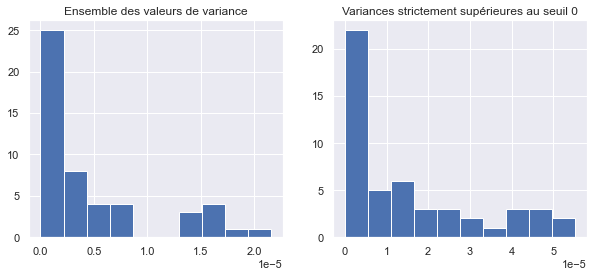

In [16]:
df_X_var_1, df_X_var_2, threshold_ = variance(run_=r__, threshold_=0, h_=50)

In [17]:
df_X_var_1.sort_values('Variance')

index      Variance
911          client_credit_card_balance_SK_DPD_min_sum  0.000000e+00
898          client_credit_card_balance_SK_DPD_min_min  0.000000e+00
899     client_credit_card_balance_SK_DPD_DEF_min_mean  0.000000e+00
900  client_POS_CASH_balance_NAME_CONTRACT_STATUS_X...  0.000000e+00
901  previous_application_NAME_GOODS_CATEGORY_House...  0.000000e+00
..                                                 ...           ...
4             previous_application_AMT_APPLICATION_sum  1.750434e+12
3      client_credit_card_balance_AMT_BALANCE_sum_mean  3.255755e+12
2                            bureau_AMT_CREDIT_SUM_max  3.850924e+12
1    client_credit_card_balance_AMT_CREDIT_LIMIT_AC...  1.172435e+13
0                            bureau_AMT_CREDIT_SUM_sum  1.488498e+13

[912 rows x 2 columns]

In [18]:
Markdown("""
>Le seuil de variance est fixé à **{seuil}**.  
Le dataframe initial contient **{nb_var_1}** variables dont **{nb_var_2}** avec une variance supérieure à **{seuil}**.

On applique la méthode `VarianceThreshold` sur le dataframe initial.  
Pour cela on créé d'abord une liste (features_name) avec les noms des variables du dataframe initial.
""".format(seuil=threshold_,nb_var_1=df_X_var_1.shape[0],nb_var_2=df_X_var_2.shape[0]))


>Le seuil de variance est fixé à **0**.  
Le dataframe initial contient **912** variables dont **898** avec une variance supérieure à **0**.

On applique la méthode `VarianceThreshold` sur le dataframe initial.  
Pour cela on créé d'abord une liste (features_name) avec les noms des variables du dataframe initial.


In [19]:
feature_names = X.columns.tolist()
print('Nombre initial de variables:',len(feature_names))

Nombre initial de variables: 912


In [20]:
from sklearn.feature_selection import VarianceThreshold

In [21]:
def varThreshold(run_, threshold_):
    
    if run_ == 0:        
        feature_names_vt = joblib.load(path_feature_selection+df_app_name+'_feature_names_vt.joblib')
    
    elif run_ == 1:
        selector_vt = VarianceThreshold(threshold = threshold_)
        selector_vt.fit_transform(X) # Attention, VT applique l'inégalité stricte et retient les variables
                                     # dont la variance est strictement > threshold
        feature_names_vt = np.array(feature_names)[selector_vt.get_support()]
        
        joblib.dump(feature_names_vt, path_feature_selection+df_app_name+'_feature_names_vt.joblib')  
        
    return feature_names_vt

In [22]:
varThreshold(r__, threshold_)
feature_names_vt = varThreshold(0, threshold_)
print('Nombre de variables supérieures au seuil:',len(feature_names_vt))

Nombre de variables supérieures au seuil: 898


On conserve finalement uniquement les variables dont la variance est supérieure au seuil.

In [23]:
X = X[feature_names_vt]
print('Dimensions du jeu de données X:',X.shape)

Dimensions du jeu de données X: (307511, 898)


On met à jour la liste des noms de variables.

In [24]:
feature_names = X.columns.tolist()
print('Nombre de variables:',len(feature_names))

Nombre de variables: 898


In [25]:
time_calc('Seuil de variance - '+df_app_name,'')
t = time.time()

Durée de l'opération 'Seuil de variance - df_app_2': 2.01 s


### Jeux d'entraînement et de test <a class="anchor" id="jeu_ent_tes"></a>

On créé un jeu d'entraînement et un jeu de test à partir du dataframe X et des étiquettes y.

In [26]:
X.head(2)

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      100002             0          202500.0    406597.5      24700.5   
1      100003             0          270000.0   1293502.5      35698.5   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   

   DAYS_ID_PUBLISH  ...  \
0            -2120  ...   
1             -291  ...   

   client_credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm_mean  \
0                                                0.0                           
1                                                0.0                           

   client_credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_mean  \
0                                                0.0                   
1                                                0.0                   

   client_credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm_mean  \
0                                                0.0                        
1                                                0.0                        

   client_credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_mean  \
0                                                0.0                    
1                                                0.0                    

   client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_mean  \
0                                                0.0                          
1                                                0.0                          

   client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_mean  \
0                                                0.0                   
1                                                0.0                   

   client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean  \
0                                                0.0                        
1                                                0.0                        

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  
0      0.083037      0.262949      0.139376  
1      0.311267      0.622246      0.598382  

[2 rows x 898 columns]

In [27]:
y.head(2)

0    1
1    0
Name: TARGET, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = rs_)

print('Jeu d\'entraînement: x_train',x_train.shape)
print('Etiquettes: y_train',y_train.shape)
print('\nJeu de test: x_test',x_test.shape)
print('Etiquettes: y_test',y_test.shape)

Jeu d'entraînement: x_train (246008, 898)
Etiquettes: y_train (246008,)

Jeu de test: x_test (61503, 898)
Etiquettes: y_test (61503,)


In [29]:
# On récupère les identifiants du jeu d'entraînement
train_ids = x_train['SK_ID_CURR']

# On récupère les identifiants du jeu de test
test_ids = x_test['SK_ID_CURR']

joblib.dump(test_ids, path_features+df_app_name+'_test_ids.joblib')

# On supprime les identifiants des jeux d'entraînement et de test
x_train = x_train.drop(columns = ['SK_ID_CURR'])
x_test = x_test.drop(columns = ['SK_ID_CURR'])

In [30]:
x_train.head(2)

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
65686              1          180000.0    269550.0      16285.5   
200800             0          270000.0   1800000.0      52632.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
65686                     0.003818      -12736          -4620   
200800                    0.018801      -21705          -2495   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  \
65686             -6831.0            -4568          0.0  ...   
200800            -6404.0            -3979          0.0  ...   

        client_credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm_mean  \
65686                                                 0.0                           
200800                                                0.0                           

        client_credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_mean  \
65686                                                 0.0                   
200800                                                0.0                   

        client_credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm_mean  \
65686                                                 0.0                        
200800                                                0.0                        

        client_credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_mean  \
65686                                                 0.0                    
200800                                                0.0                    

        client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_mean  \
65686                                                 0.0                          
200800                                                0.0                          

        client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_mean  \
65686                                                 0.0                   
200800                                                0.0                   

        client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean  \
65686                                                 0.0                        
200800                                                0.0                        

        EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  
65686       0.333415      0.684643      0.114652  
200800      0.888750      0.154848      0.634706  

[2 rows x 897 columns]

In [31]:
x_test.head(2)

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
179042             0           67500.0   1030302.0      40860.0   
269683             0           90000.0    253737.0      26775.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
179042                    0.004960      -19842          -3001   
269683                    0.009175      -16820           -445   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  \
179042            -8588.0            -2278         12.0  ...   
269683            -6378.0             -355         65.0  ...   

        client_credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm_mean  \
179042                                                0.0                           
269683                                                0.0                           

        client_credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_mean  \
179042                                                0.0                   
269683                                                0.0                   

        client_credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm_mean  \
179042                                                0.0                        
269683                                                0.0                        

        client_credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_mean  \
179042                                                0.0                    
269683                                                0.0                    

        client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_mean  \
179042                                                0.0                          
269683                                                0.0                          

        client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_mean  \
179042                                                0.0                   
269683                                                0.0                   

        client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean  \
179042                                                0.0                        
269683                                                0.0                        

        EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  
179042      0.835209      0.515916      0.612704  
269683      0.420288      0.730601      0.712155  

[2 rows x 897 columns]

In [32]:
time_calc('Jeux d\'entraînement et de test - '+df_app_name,'')
t = time.time()

Durée de l'opération "Jeux d'entraînement et de test - df_app_2": 3.96 s


### Modélisation du traitement des données du jeu d'entraînement <a class="anchor" id="mod_tra_don"></a>

Il y a un fort déséquilibre entre les classes de données, les dossiers négatifs (crédits remboursés) sont sur-représentés.

>On va donc procéder à des traitements sur le jeu d'entraînement pour réduire le déséquilibre.

Le jeu de test n'est pour sa part pas modifié.

In [33]:
test_features = x_test
test_labels = y_test

# On procède à quelques modifications des noms de variables
# pour être en conformité avec les critères de LightGBM

#https://www.kaggle.com/c/data-science-bowl-2019/discussion/122021
import re
test_features = test_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
#https://www.kaggle.com/c/data-science-bowl-2019/discussion/120344
test_features.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_features.columns]

joblib.dump(test_features, path_features + df_app_name + '_test_features.joblib')
joblib.dump(test_labels, path_features + df_app_name+ '_test_labels.joblib')

['../OC_DS_P7/features/df_app_2_test_labels.joblib']

In [34]:
from collections import Counter
 # doctest: +NORMALIZE_WHITESPACE

In [35]:
def features_processing(run_, sampling_strategy_, features, labels):
    
    """Traitemement du jeu d'entraînement
    
    Paramètres
        features: jeu d'entraînement
        labels: étiquettes du jeu d'entraînement
    Sorties
        feature_names: nom des variables
        features: jeu d'entraînement traité
        labels: étiquettes du jeu d'entraînement traité
    """
    
    print('\nDimensions du jeu d\'entraînement avant traitement:', features.shape)
    
    strat_ = str(sampling_strategy_)
    
    if run_ == 1:
    
        # # Sur-échantillonnage en utilisant la méthode Smote
        if sampling_strategy_ == 1:
            
            from imblearn.over_sampling import SMOTE
            #smote = SMOTE(sampling_strategy='auto', random_state=rs_, k_neighbors=7)            
            smote = SMOTE(sampling_strategy = smote_ratio_, random_state = rs_)
            features_smote, labels_smote = smote.fit_sample(features, labels)

            features = features_smote
            labels = labels_smote
        
        # Sous-échantillonnage en utilisant la méthode NearMiss
        elif sampling_strategy_ == 2:
            
            from imblearn.under_sampling import NearMiss
            # Taille du nouveau dataset
            distribution_of_samples = {0:int(0.8*(y_train.shape[0] - y_train.sum())), # Nombre d'étiquettes = 0
                                       1:y_train.sum()} # Nombre d'étiquettes = 1
            
            nearmiss = NearMiss(sampling_strategy = distribution_of_samples)
            X_under_sample, y_under_sample = nearmiss.fit_sample(features, labels)
            
            features = X_under_sample
            labels = y_under_sample            
        
        # Sous-échantillonnage en utilisant la méthode TomekLinks
        elif sampling_strategy_ == 3:
            
            from imblearn.under_sampling import TomekLinks
            
            tl = TomekLinks(sampling_strategy = 'auto') # Stratégie par défaut: sous-échantillonnage classe majoritaire (0)
            features_tomeklinks, labels_tomeklinks = tl.fit_resample(features, labels)
            
            features = features_tomeklinks
            labels = labels_tomeklinks

        import re
        features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        features.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features.columns]
      
        # Les noms de certaines colonnes ont été modifiés
        feature_names = list(features.columns)

        joblib.dump(feature_names, path_features+df_app_name+'_'+strat_+'_feature_names.joblib')
        joblib.dump(features, path_features+df_app_name+'_'+strat_+'_features.joblib')
        joblib.dump(labels, path_features+df_app_name+'_'+strat_+'_labels.joblib')
 
        print('Dimensions du jeu d\'entraînement après traitement:', features.shape)
        print('')
        
    elif run_ == 0:
        
        feature_names = joblib.load(path_features+df_app_name+'_'+strat_+'_feature_names.joblib')
        features = joblib.load(path_features+df_app_name+'_'+strat_+'_features.joblib')
        labels = joblib.load(path_features+df_app_name+'_'+strat_+'_labels.joblib')
        
        print('Dimensions du jeu d\'entraînement après traitement:', features.shape)
    
    return feature_names, features, labels

### Traitement des données<a class="anchor" id="tra_don"></a>

On créé différents jeux de données dont 1 jeu avec sur-échantillonange et 1 jeu avec sous-échantillonnage.

**Stratégie 0** - Sans traitement

In [36]:
feature_names_0, features_0, labels_0 = features_processing(r__,
                                                            0, # Stratégie sans traitement
                                                            x_train, y_train)

time_calc('Sans traitement des données - '+df_app_name)
t = time.time()


Dimensions du jeu d'entraînement avant traitement: (246008, 897)
Dimensions du jeu d'entraînement après traitement: (246008, 897)
Durée de l'opération 'Sans traitement des données - df_app_2': 19.92 s


**Stratégie 1** - Traitement `Smote` sur-échantillonange (over-sampling)

In [37]:
feature_names_1, features_1, labels_1 = features_processing(r__,
                                                            1, # Stratégie Smote
                                                            x_train, y_train)

time_calc('Sur-échantillonnage Smote - '+df_app_name,'145')
t = time.time()


Dimensions du jeu d'entraînement avant traitement: (246008, 897)
Dimensions du jeu d'entraînement après traitement: (271398, 897)
Durée de l'opération 'Sur-échantillonnage Smote - df_app_2': 10.58 s


**Stratégie 2** - Traitement `NearMiss` sous-échantillonnage (under-sampling)

In [38]:
feature_names_2, features_2, labels_2 = features_processing(r__,
                                                            2, # Stratégie NearMiss
                                                            x_train, y_train)

time_calc('Sous-échantillonnage NearMiss - '+df_app_name,1286)
t = time.time()


Dimensions du jeu d'entraînement avant traitement: (246008, 897)
Dimensions du jeu d'entraînement après traitement: (200775, 897)
Durée de l'opération 'Sous-échantillonnage NearMiss - df_app_2': 7.45 s


**Stratégie 3** - Traitement `TomekLinks` sous-échantillonnage (under-sampling)

In [39]:
feature_names_3, features_3, labels_3 = features_processing(r__,
                                                            3, # Stratégie TomekLinks
                                                            x_train, y_train)

time_calc('Sous-échantillonnage TomekLinks - '+df_app_name,'2933')
t = time.time()


Dimensions du jeu d'entraînement avant traitement: (246008, 897)
Dimensions du jeu d'entraînement après traitement: (238830, 897)
Durée de l'opération 'Sous-échantillonnage TomekLinks - df_app_2': 9.45 s


### Dimensions des jeux d'entraînement et de test<a class="anchor" id="dim_jeu_ent_tes"></a>

Les différents traitements ont modifié les dimensions de jeu d'entraînement en ajoutant ou en supprimant des individus en vue d'augmenter le ratio de dossiers positifs (1).

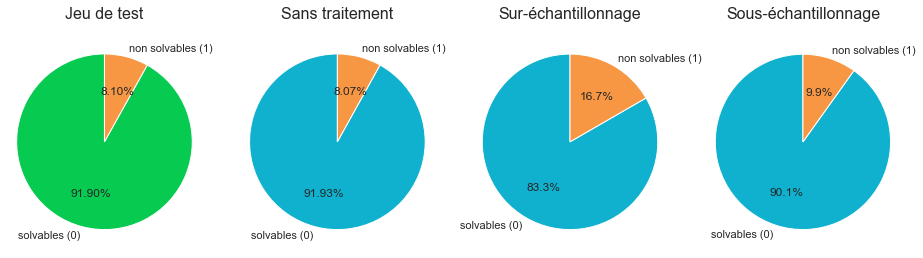

Données            Traitement  Individus  Non solvables (1)  Solvables (0)  \
0    Test                   Non      61503               4982          56521   
1   Train                   Non     246008              19843         226165   
2   Train   Sur-échantillonnage     271398              45233         226165   
3   Train  Sous-échantillonnage     200775              19843         180932   

   % Non solvables (1)  
0                 8.10  
1                 8.07  
2                16.67  
3                 9.88

In [40]:
import matplotlib.pyplot as plt

labels_ = 'solvables (0)', 'non solvables (1)'
sizes_0 = [Counter(test_labels)[0], Counter(test_labels)[1]] # Jeu de test
sizes_1 = [Counter(labels_0)[0], Counter(labels_0)[1]] # Jeu d'entraînement
sizes_2 = [Counter(labels_1)[0], Counter(labels_1)[1]] # Jeu d'entraînement over-sampling
sizes_3 = [Counter(labels_2)[0], Counter(labels_2)[1]] # Jeu d'entraînement under-sampling
explode = (0, 0.1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))

ax1.pie(sizes_0,
        #explode=explode,
        labels=labels_,
        autopct='%1.2f%%',
        colors=['#07CA51','#F79743'],
        #shadow=True,
        startangle=90)

ax2.pie(sizes_1,
        #explode=explode,
        labels=labels_,
        autopct='%1.2f%%',
        colors=['#10B1CE','#F79743'],
        #shadow=True,
        startangle=90)

ax3.pie(sizes_2,
        #explode=explode,
        labels=labels_,
        autopct='%1.1f%%',
        colors=['#10B1CE','#F79743'],
        #shadow=True,
        startangle=90)

ax4.pie(sizes_3,
        #explode=explode,
        labels=labels_,
        autopct='%1.1f%%',
        colors=['#10B1CE','#F79743'],
        #shadow=True,
        startangle=90)

ax1.axis('equal')
ax2.axis('equal')
ax3.axis('equal')
ax4.axis('equal')

dict = {'fontsize': 16,
        'fontweight' : 1,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}

ax1.set_title('Jeu de test', fontdict=dict, pad=15)
ax2.set_title('Sans traitement', fontdict=dict, pad=15)
ax3.set_title('Sur-échantillonnage', fontdict=dict, pad=15)
ax4.set_title('Sous-échantillonnage', fontdict=dict, pad=15)

plt.show()

def ratio_(a,b):
    return round((100*b/(a+b)),2)

dim = {'Données':['Test','Train','Train','Train'],
       'Traitement':['Non','Non','Sur-échantillonnage','Sous-échantillonnage'],
       'Individus':[test_features.shape[0],
                    features_0.shape[0],
                    features_1.shape[0],
                    features_2.shape[0]],
       'Non solvables (1)':[Counter(test_labels)[1],
                            Counter(labels_0)[1],
                            Counter(labels_1)[1],
                            Counter(labels_2)[1]],
       'Solvables (0)':[Counter(test_labels)[0],
                        Counter(labels_0)[0],
                        Counter(labels_1)[0],
                        Counter(labels_2)[0]],
       '% Non solvables (1)':[(ratio_(Counter(test_labels)[0],Counter(test_labels)[1])),
                              (ratio_(Counter(labels_0)[0],Counter(labels_0)[1])),
                              (ratio_(Counter(labels_1)[0],Counter(labels_1)[1])),
                              (ratio_(Counter(labels_2)[0],Counter(labels_2)[1]))]
       }

pd.DataFrame(dim)

In [41]:
print('La stratégie de traitement du déséquilibre des données est:',strat_)

La stratégie de traitement du déséquilibre des données est: 1


Nous définissons le jeu de données suivant la stratégie adoptée.

In [42]:
# Stratégie 0 - Sans traitement
if strat_ == 0:    
    feature_names = feature_names_0
    features = features_0
    labels = labels_0

# Stratégie 1 - Sur-échantillonnage
elif strat_ == 1:
    feature_names = feature_names_1
    features = features_1
    labels = labels_1

# Stratégie 2 - Sous-échantillonnage
elif strat_ == 2:
    feature_names = feature_names_2
    features = features_2
    labels = labels_2
    
strat_ = str(strat_)

In [43]:
time_calc('Traitement des données - '+df_app_name,'',1)
t = time.time()

Durée de l'opération 'Traitement des données - df_app_2': 2.05 s
Durée totale de traitement: 00 h 01 m 05 s


## Machine Learning <a class="anchor" id="mac_lea"></a>

Nous allons entraîner différents classifieurs et évaluer leurs performances sur différents jeux de données.

>Nous pourrons ainsi évaluer du même coup les classifieurs et les traitements pour équilibrer les données.

La métrique adaptée est la courbe **ROC** (Receiver Operating Characteristic) et la mesure **AUC** (Area Under the Curve) à maximiser.

Pour faciliter l'évaluation des différents modèles, nous avons créé une fonction qui prend principalement en entrée:
+ Les données d'entraînement et de test
+ Les étiquettes des jeux d'entraînement et de test (cible)
+ Le type de classifieur

La fonction comprend l'entraînement des modèles par validation croisée, les prédictions et les évaluations.

On obtient en sortie:

+ Les prédictions sur le jeu d'entraînement (train_pred)
+ Les prédictions sur le jeu de test (test_pred)
+ Les variables importantes (feat_imp)
+ Les mesures de performance et l'affichage de la courbe ROC

Les prédictions sur la base du modèle entraîné représentent la probabilité que le crédit ne soit pas remboursé (valeur 1).

In [44]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

### Modélisation <a class="anchor" id="mod"></a>

In [45]:
cl_0 = '#33CC00' # vert
cl_1 = '#000000' # noir

cls_att = {'model_version':['lr_1','rf_1','xgb_1','catb_1','lgbm_1','lgbm_1b','lgbm_2','lgbm_2b','lgbm_3','lgbm_4'],
           'color_code':['#808080','#F57F17',cl_0,'#000000','#DC1438',cl_1,'#DC1438',cl_1,cl_1,'#F57235'],
           'color_name':['gris','orange','cl_0','noir','rouge','cl_1','rouge','cl_1','cl_1','orange'],
           'line_style':['--','-','-','-',':','-',':','-','-','--'],
           'line_width':[1,2,2,1,3,1,3,1,1,1]}

df_cls_att = pd.DataFrame(cls_att, index=[1,2,3,4,5,6,7,8,9,10])
df_cls_att.set_index('model_version', inplace=True)
df_cls_att

color_code color_name line_style  line_width
model_version                                             
lr_1             #808080       gris         --           1
rf_1             #F57F17     orange          -           2
xgb_1            #33CC00       cl_0          -           2
catb_1           #000000       noir          -           1
lgbm_1           #DC1438      rouge          :           3
lgbm_1b          #000000       cl_1          -           1
lgbm_2           #DC1438      rouge          :           3
lgbm_2b          #000000       cl_1          -           1
lgbm_3           #000000       cl_1          -           1
lgbm_4           #F57235     orange         --           1

In [46]:
from timeit import default_timer as timer

In [47]:
def cls_training(run_, cls_model_, cls_model_version_, features, labels, test_features=test_features,
                 test_labels=test_labels, test_ids=test_ids, strat_=strat_, mod_dump_=1, n_folds=5):
    
    if run_ == 0:
        
        submission = joblib.load(path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_submission.joblib')
        train_pred = joblib.load(path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_train_pred.joblib')
        test_pred = joblib.load(path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_test_pred.joblib')
        feat_imp = joblib.load(path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_feat_imp.joblib')
        val_metrics = joblib.load(path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_val_metrics.joblib')
        df_eval = joblib.load(path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_df_eval.joblib')
        
        [fpr, tpr, thr] = joblib.load(path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_fpr_tpr_thr.joblib')
    
    elif run_ == 1:
        
        cls_dim_list = []
        cls_name_list = []
        cls_train_auc_list = []
        cls_test_auc_list = []
        cls_run_time_list = []
        
        # Conversion des features en tableau numpy
        features = np.array(features)
        test_features = np.array(test_features)

        # Création d'un objet kfold
        k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = rs_)

        # Initialisation de la matrice de l'importance des variables 
        feature_importance_values = np.zeros(len(feature_names))
        # Initialisation de la matrice des prédictions de test
        test_pred = np.zeros(test_features.shape[0])
        # Initialisation de la matrice des prédictions d'entraînement
        train_pred = np.zeros(features.shape[0])
        # Initialisation de la matrice des prédictions de validation de sortie de kfold
        out_of_fold = np.zeros(features.shape[0])

        # Initialisation des listes de scores
        valid_scores = []
        train_scores = []

        # Itération sur chaque fold
        k = 1 # indice utilisé pour distinguer les résultats en cours d'entraînement
        kf = 0 # indice utilisé pour sauvegarder les différents modèles (n_folds)
        
        start = timer()
    
        for train_indices, valid_indices in k_fold.split(features):
            k += 1
            kf += 1
            # Données d'entraînement
            train_features, train_labels = features[train_indices], labels.iloc[train_indices]
            # Données de validation
            valid_features, valid_labels = features[valid_indices], labels.iloc[valid_indices]

            # Création du modèle
            model = cls_model_

            # Entraînement du modèle
            if 'lr_' in cls_model_version_ or 'rf_' in cls_model_version_:
                model.fit(train_features, train_labels)
                
            elif 'xgb_' in cls_model_version_:
                model.fit(train_features, train_labels,
                          eval_metric = 'auc',
                          eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                          early_stopping_rounds = 100,
                          verbose = False)

            elif 'lgbm_' in cls_model_version_:
                model.fit(train_features, train_labels,
                          eval_metric = 'auc',
                          eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                          eval_names = ['valid', 'train'],
                          #categorical_feature = None,
                          early_stopping_rounds = 100,
                          verbose = False)
            
            else:
                model.fit(train_features, train_labels,
                          use_best_model = True,
                          eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                          early_stopping_rounds = 100,
                          verbose = False)
            
            # Sauvegarde du modèle
            if mod_dump_ == 1:
                joblib.dump(model, path_models+df_app_name+'_'+strat_+'_'+cls_model_version_+'_'+str(kf)+'.joblib')

            # Meilleure itération
            if 'xgb_' in cls_model_version_:
                ntree_limit_ = model.best_ntree_limit
            elif 'lgbm_' in cls_model_version_:
                best_iteration = model.best_iteration_
            elif 'catb_' in cls_model_version_:
                best_iteration = model.get_best_iteration()

            # Importance des variables
            if 'lr_' not in cls_model_version_:
                feature_importance_values += model.feature_importances_ / k_fold.n_splits

            # Prédictions des données de test
            if 'xgb_' in cls_model_version_:
                train_pred += model.predict_proba(features, ntree_limit = ntree_limit_)[:,1] / k_fold.n_splits
                test_pred += model.predict_proba(test_features, ntree_limit = ntree_limit_)[:,1] / k_fold.n_splits
                          
            elif 'lgbm_' in cls_model_version_:    
                train_pred += model.predict_proba(features, num_iteration = best_iteration)[:,1] / k_fold.n_splits
                test_pred += model.predict_proba(test_features, num_iteration = best_iteration)[:,1] / k_fold.n_splits          
            
            else:
                train_pred += model.predict_proba(features)[:, 1] / k_fold.n_splits
                test_pred += model.predict_proba(test_features)[:, 1] / k_fold.n_splits

            # Prédictions des données de validation (sortie k-fold)
            out_of_fold[valid_indices] = model.predict_proba(valid_features)[:,1]

            # Meilleur score
            if 'lr_' in cls_model_version_ or 'rf_' in cls_model_version_:
                valid_score = round(model.score(valid_features, valid_labels) *100,2)
                train_score = round(model.score(train_features, train_labels) *100,2)                
            elif 'xgb_' in cls_model_version_:
                evals_result = model.evals_result()
                valid_score = max(evals_result['validation_1']['auc'])
                train_score = max(evals_result['validation_0']['auc'])
            elif 'catb_' in cls_model_version_:  
                evals_result = pd.DataFrame(model.evals_result_)
                valid_score = max(evals_result['validation_0'].loc['AUC']) # ou 'Logloss'
                train_score = max(evals_result['validation_1'].loc['AUC']) # ou 'Logloss'
            elif 'lgbm_' in cls_model_version_:
                valid_score = model.best_score_['valid']['auc']
                train_score = model.best_score_['train']['auc']
   
            valid_scores.append(valid_score)
            train_scores.append(train_score)

            # On vide la mémoire
            gc.enable()
            del model, train_features, valid_features
            gc.collect()
            
        run_time = round((timer() - start),0)
        cls_run_time_list.append(run_time)
        
        # Dataframe submission
        submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_pred})
        
        # Dataframe de l'importance des variables
        feat_imp = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
        
        # Score de validation global
        valid_auc = roc_auc_score(labels, out_of_fold) # Pour lr et rf on utilise l'accuracy comme meilleur score
        
        # Ajout du score de validation global aux métriques
        valid_scores.append(valid_auc)
        train_scores.append(np.mean(train_scores))

        fold_names = list(range(n_folds))
        fold_names.append('overall')

        # Dataframe des scores de validation
        val_metrics = pd.DataFrame({'fold': fold_names,
                                    'train': train_scores,
                                    'valid': valid_scores})
        
        cls_dim_list.append(features.shape)
        cls_name_list.append(cls_model_version_)
        
        # Sauvegarde des résultats
        joblib.dump(submission, path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_submission.joblib')
        joblib.dump(train_pred, path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_train_pred.joblib')
        joblib.dump(test_pred, path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_test_pred.joblib')
        joblib.dump(feat_imp, path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_feat_imp.joblib')
        joblib.dump(val_metrics, path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_val_metrics.joblib')
        
        
        [fpr, tpr, thr] = metrics.roc_curve(labels, train_pred)
        cls_train_auc_list.append(metrics.auc(fpr, tpr))
        
        [fpr, tpr, thr] = metrics.roc_curve(test_labels, test_pred)
        cls_test_auc_list.append(metrics.auc(fpr, tpr))

        df_eval = pd.DataFrame({'Features dim':cls_dim_list,
                                'Model': cls_name_list,
                                'Train score': cls_train_auc_list,
                                'Test score': cls_test_auc_list,
                                'Run time': cls_run_time_list}).sort_values('Test score', ascending=False)

        joblib.dump(df_eval, path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_df_eval.joblib')
        
        # Sauvegarde des metrics
        joblib.dump(fpr, path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_fpr.joblib') # utile ?
        joblib.dump(tpr, path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_tpr.joblib') # utile ?
        joblib.dump(thr, path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_thr.joblib') # utile ?
        joblib.dump([fpr, tpr, thr], path_results+df_app_name+'_'+strat_+'_'+cls_model_version_+'_fpr_tpr_thr.joblib')
        
        # Courbe ROC-AUC
        plt.plot(fpr, tpr, color=df_cls_att.loc[cls_model_version_,'color_code'], label=cls_model_version_,
                 lw=df_cls_att.loc[cls_model_version_,'line_width'],
                 ls=df_cls_att.loc[cls_model_version_,'line_style'])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1 - Spécificité', fontsize=14)
        plt.ylabel('Sensibilité', fontsize=14)
        plt.legend(loc="lower right")
    
    return submission, train_pred, test_pred, feat_imp, val_metrics, df_eval

### Classifieurs <a class="anchor" id="cla"></a>

Nous avons testé 1 classifieur linéaire `LogisticRegression` et 4 classifieurs basés sur les arbres de décision:
+ `Random Forest`
+ `XGBoost`
+ `CatBoost`
+ `LightGBM`

Nous avons configuré les classifieurs avec leurs paramètres par défaut.

#### Logistic Regression <a class="anchor" id="log_reg"></a>

In [48]:
from sklearn.linear_model import LogisticRegression

lr_version_ = 'lr_1'
lr_1 = LogisticRegression(C = 0.0001, # paramètre de régularisation
                          random_state = rs_,
                          verbose = 0)
lr_1.get_params()

{'C': 0.0001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 45,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Random Forest <a class="anchor" id="ran_for"></a>

In [49]:
from sklearn.ensemble import RandomForestClassifier

rf_version_ = 'rf_1'
rf_1 = RandomForestClassifier(n_estimators = 100,
                              n_jobs = -1,
                              random_state = rs_,
                              verbose = 0)
rf_1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 45,
 'verbose': 0,
 'warm_start': False}

#### XGBoost <a class="anchor" id="xgb"></a>

In [50]:
import xgboost
print('xgboost version:',xgboost.__version__)
from xgboost import XGBClassifier

xgb_version_ = 'xgb_1'
xgb_1 = XGBClassifier(importance_type = 'gain',
                      random_state = rs_)
xgb_1.get_params()

xgboost version: 1.1.1


{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 45,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

#### CatBoost <a class="anchor" id="cat"></a>

In [51]:
import catboost
print('catboost version:',catboost.__version__)
from catboost import CatBoostClassifier

catb_version_ = 'catb_1'
catb_1 = CatBoostClassifier(eval_metric = 'AUC',
                            depth = 10,
                            iterations = 100,
                            l2_leaf_reg = 9,
                            learning_rate = 0.15,
                            random_state = rs_)
catb_1.get_params()

catboost version: 0.23.2


{'iterations': 100,
 'learning_rate': 0.15,
 'depth': 10,
 'l2_leaf_reg': 9,
 'eval_metric': 'AUC',
 'random_state': 45}

#### LightGBM <a class="anchor" id="lgb"></a>

In [52]:
import lightgbm
print('lightgbm version:',lightgbm.__version__)
from lightgbm import LGBMClassifier

lgbm_version_ = 'lgbm_1'
lgbm_1 = LGBMClassifier(objective = 'binary',
                        #n_estimators=2000,
                        class_weight = 'balanced',
                        #class_weight = None,
                        #reg_alpha = 0.1,
                        #reg_lambda = 0.1,
                        #subsample = 0.8,
                        n_jobs = -1,
                        random_state = rs_)
lgbm_1.get_params()

lightgbm version: 2.3.1


{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 45,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [53]:
time_calc('Modélisation Machine Learning - '+df_app_name,'',1)
t = time.time()

Durée de l'opération 'Modélisation Machine Learning - df_app_2': 0.55 s
Durée totale de traitement: 00 h 01 m 06 s


### Entraînement des classifieurs <a class="anchor" id="ent_cla"></a>

In [54]:
models_ = [lr_1, rf_1, xgb_1, catb_1, lgbm_1]
model_names_ = ['lr_1', 'rf_1', 'xgb_1', 'catb_1', 'lgbm_1']

In [55]:
def roc_plot(strat):
    if r__ == 0:
        model_auc_ = []
        plt.figure(figsize=(8,6))
        for model_name_ in model_names_:
            [fpr, tpr, thr] = joblib.load(path_results+df_app_name+'_'+str(strat)+'_'+model_name_+'_fpr_tpr_thr.joblib')
            
            # Calcul de la mesure AUC
            auc = round(metrics.auc(fpr, tpr),3)   
            # Etiquette
            model_auc = model_name_+' (AUC = '+str(auc)+')'
            # Ajout de l'étiquette à la liste
            model_auc_.append(model_auc)
            
            
            plt.plot(fpr, tpr, color=df_cls_att.loc[model_name_,'color_code'], label=model_name_,
                     lw=df_cls_att.loc[model_name_,'line_width'],
                     ls=df_cls_att.loc[model_name_,'line_style'])
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1 - Spécificité', fontsize=14)
        plt.ylabel('Sensibilité', fontsize=14)
        plt.legend(model_auc_, loc="lower right");

**Stragégie 0** - Sans traitement

Features dim   Model  Train score  Test score  Run time
4  (246008, 897)  lgbm_1        0.868       0.835     289.0
2  (246008, 897)   xgb_1        0.895       0.834    3389.0
3  (246008, 897)  catb_1        0.874       0.831    1854.0
1  (246008, 897)    rf_1        1.000       0.790    1041.0
0  (246008, 897)    lr_1        0.613       0.607     132.0

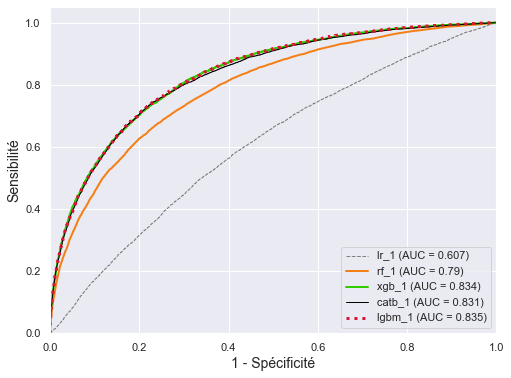

In [56]:
# Initialisation du dataframe d'évaluations
df_eval_all = pd.DataFrame({'Features dim':[],'Model':[],'Train score':[],'Test score':[],'Run time':[]})

for model_, model_name_ in zip(models_, model_names_) :
    submission, train_pred, test_pred, feat_imp, val_metrics, df_eval = cls_training(r__, model_, model_name_,
                                                                                     features_0, labels_0,
                                                                                     test_features, test_labels, test_ids,
                                                                                     str(0))
    df_eval_all = pd.concat([df_eval_all, df_eval])
    df_eval_all.reset_index(drop=True,inplace=True)
    
roc_plot(0)
round((df_eval_all.sort_values('Test score', ascending=False)),3)

**Stratégie 1** - Sur-échantillonnage `Smote`

Features dim   Model  Train score  Test score  Run time
2  (271398, 897)   xgb_1        0.955       0.834    3934.0
4  (271398, 897)  lgbm_1        0.936       0.833     354.0
3  (271398, 897)  catb_1        0.942       0.831    2499.0
1  (271398, 897)    rf_1        1.000       0.790     971.0
0  (271398, 897)    lr_1        0.631       0.619     143.0

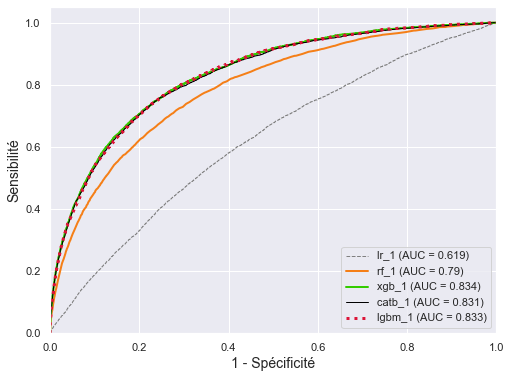

In [57]:
# Initialisation du dataframe d'évaluations
df_eval_all = pd.DataFrame({'Features dim':[],'Model':[],'Train score':[],'Test score':[],'Run time':[]})

for model_, model_name_ in zip(models_, model_names_) :
    submission, train_pred, test_pred, feat_imp, val_metrics, df_eval = cls_training(r__, model_, model_name_,
                                                                                     features_1, labels_1,
                                                                                     test_features, test_labels, test_ids,
                                                                                     str(1))
    df_eval_all = pd.concat([df_eval_all, df_eval])
    df_eval_all.reset_index(drop=True,inplace=True)

roc_plot(1)
round((df_eval_all.sort_values('Test score', ascending=False)),3)

**Stratégie 2** - Sous-échantillonnage `NearMiss`

Features dim   Model  Train score  Test score  Run time
4  (200775, 897)  lgbm_1        0.885       0.778     231.0
2  (200775, 897)   xgb_1        0.912       0.765    2728.0
3  (200775, 897)  catb_1        0.883       0.764    1580.0
1  (200775, 897)    rf_1        1.000       0.722     853.0
0  (200775, 897)    lr_1        0.657       0.593     102.0

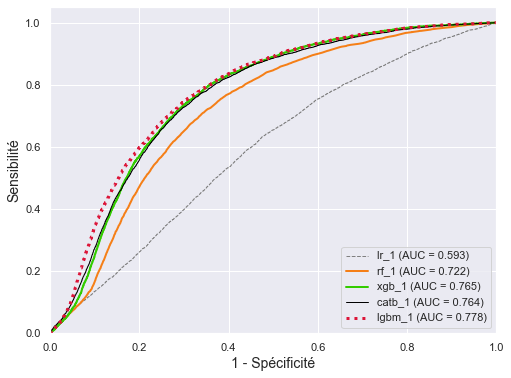

In [58]:
# Initialisation du dataframe d'évaluations
df_eval_all = pd.DataFrame({'Features dim':[],'Model':[],'Train score':[],'Test score':[],'Run time':[]})

for model_, model_name_ in zip(models_, model_names_) :
    submission, train_pred, test_pred, feat_imp, val_metrics, df_eval = cls_training(r__, model_, model_name_,
                                                                                     features_2, labels_2,
                                                                                     test_features, test_labels, test_ids,
                                                                                     str(2))
    df_eval_all = pd.concat([df_eval_all, df_eval])
    df_eval_all.reset_index(drop=True,inplace=True)

roc_plot(2)
round((df_eval_all.sort_values('Test score', ascending=False)),3)

>Les meilleurs résultats basés sur la métrique **AUC** sont obtenus avec le traitement des données par sur-échantillonnage avec la méthode `Smote` (stratégie 1).

In [59]:
time_calc('Entraînement des classifieurs - '+df_app_name,'21260')
t = time.time()

Durée de l'opération 'Entraînement des classifieurs - df_app_2': 1.6 s


## Réduction de dimension <a class="anchor" id="red_dim"></a>

In [60]:
Markdown("""
Nous disposons à ce stade du jeu de données suivant:
- Dimensions du jeu d'entraînement (features): {feat}
- Dimensions du jeu de test (test_features): {test_feat} 
""".format(feat=features.shape,test_feat=test_features.shape))


Nous disposons à ce stade du jeu de données suivant:
- Dimensions du jeu d'entraînement (features): (271398, 897)
- Dimensions du jeu de test (test_features): (61503, 897) 


In [61]:
X = features
y = labels

On se propose de réduire le nombre de variables pour optimiser les opérations ultérieures.

Il existe de nombreuses méthodes de réduction de variables. Nous avons mis en oeuvre les méthodes suivantes:

+ Méthode 1: Réaliser une combinaison des **variables importantes** des résultats d'entraînement de certains classifieurs
+ Méthode 2: Recursive Feature Elimination (RFE)

### Variables les plus importantes <a class="anchor" id="var_plu_imp"></a>

Les classifieurs testés offrent une méthode d'évaluation de l'importance des variables.

On peut alors combiner les variables 'importantes' obtenues avec chaque classifieur pour constituer une liste de variables ayant potentiellement le plus d'influence. En limitant le jeu de données à ces variables on réduit d'une part la dimension du dataframe et cela peut éventuellement améliorer les résultats.

Il y a deux manières de combiner les variables 'importantes'. Dans les deux cas, on sélectionne d'abord les **n variables les plus importantes** obtenues avec chaque classifieur.

On a ensuite 2 options:
+ Option 1: On combine l'ensemble des variables et on supprime les doublons  
+ Option 2: On retient uniquement les variables communes

In [62]:
# Nombre de variables les plus importantes
feat_nb = 300

##### Option 1

In [63]:
df_fi_all = pd.DataFrame({'feature':[],'importance':[]})

models_.remove(lr_1)
model_names_.remove('lr_1')

for model_, model_name_ in zip(models_, model_names_) :
    submission, train_pred, test_pred, feat_imp, val_metrics, df_eval = cls_training(0, model_, model_name_,
                                                                                     features,
                                                                                     labels)
    df_fi = feat_imp.sort_values('importance',ascending=False).head(feat_nb)
    df_fi_all = pd.concat([df_fi_all, df_fi])
    
# Nombre de doublons
df_fi_all_dup = df_fi_all[df_fi_all.duplicated(['feature'])]
# Nombre total de variables
print('Nombre de variables:',df_fi_all.shape[0])
# Sélection des doublons
print('Nombre de doublons:',df_fi_all_dup.shape[0])
print('Nombre de variables uniques:',(df_fi_all.shape[0])-(df_fi_all_dup.shape[0]))

df_fi_all = df_fi_all.drop_duplicates(subset=['feature'], keep='last').sort_values('feature')[['feature']]
print('Nombre de variables après suppression des doublons:',df_fi_all.shape[0])

feature_names_fi_1 = df_fi_all['feature'].tolist()

Nombre de variables: 1200
Nombre de doublons: 748
Nombre de variables uniques: 452
Nombre de variables après suppression des doublons: 452


##### Option 2

In [64]:
df_fi_all = pd.DataFrame({'feature':feature_names,'importance':np.arange(len(feature_names))})

print('Nombre de variables total:',len(feature_names))

for model_, model_name_ in zip(models_, model_names_) :
    submission, train_pred, test_pred, feat_imp, val_metrics, df_eval = cls_training(0, model_, model_name_,
                                                                                     features,
                                                                                     labels)
    
    df_fi = feat_imp.sort_values('importance',ascending=False).head(feat_nb)   
    df_fi_all = df_fi_all.merge(df_fi, left_on='feature', right_on='feature')
    print('Nombre de variables communes:',df_fi_all.shape[0])

feature_names_fi_2 = df_fi_all['feature'].tolist()

Nombre de variables total: 897
Nombre de variables communes: 300
Nombre de variables communes: 191
Nombre de variables communes: 160
Nombre de variables communes: 150


In [65]:
time_calc('Importance des variables - '+df_app_name,'')
t = time.time()

Durée de l'opération 'Importance des variables - df_app_2': 0.28 s


### Recursive feature elimination (RFE) <a class="anchor" id="rec_fea_eli"></a>

**RFE** est une méthode de sélection de variables basée sur l'apprentissage d'un estimateur (classifieur dans notre cas).

Le but de l'élimination récursive des variables (**R**ecursive **F**eature **E**limination) est de sélectionner des variables en considérant de manière récursive des ensembles de variables de plus en plus petits.

L'estimateur est d'abord entraîné sur l'ensemble initial de données et l'importance de chaque variable est obtenue soit par un attribut `coef_`, soit par un attribut `feature_importances_` (suivant le type d'estimateur). **RFE** tente d'éliminer les dépendances et la colinéarité qui peuvent exister dans le modèle. Les variables les moins importantes sont ensuite supprimées de l'ensemble  des variables.

Cette procédure est répétée de manière récursive sur le nouveau jeu de données jusqu'à ce que le nombre souhaité de variables soit atteint.

Nous avons implémenté la méthode **RFE** et la méthode **RFECV** dont l'entraînement de l'estimateur est fait par validation croisée.

In [66]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

>Nous avons testé plusieurs estimateurs (`SVR`, `MultinomialNB`, `GaussianNB`, `LogisticRegression`...) et avons finalement obtenu les meilleurs résultats avec `LightGBM`, en terme de temps d'exécution et de performances.

In [67]:
#estimator = SVR(kernel="linear")    
#estimator = MultinomialNB()
#estimator = GaussianNB()
#estimator = LogisticRegression(C = 0.0001,random_state = rs_)
estimator = lgbm_1

def rfe(run_, X, selector_):
    
    if run_ == 0:
        feature_names_rfe = joblib.load(path_feature_selection+df_app_name+'_'+strat_+'_feature_names_rfe.joblib')
        rfe_support_ = joblib.load(path_feature_selection+df_app_name+'_'+strat_+'_rfe_support_.joblib')
        rfe_ranking_ = joblib.load(path_feature_selection+df_app_name+'_'+strat_+'_rfe_ranking_.joblib')
    
    elif run_ == 1:
        # Méthode RFECV (avec validation croisée)
        if selector_ == 2:

            step_ = 100
            n_features_to_select_ = 600
            print('Nombre de variables initial:',X.shape[1])
            print('step (1):',step_)
            print('n_features_to_select (1):',n_features_to_select_)
            print('')
            
            selector_rfecv = RFECV(estimator,
                                   min_features_to_select = n_features_to_select_,
                                   step = step_,
                                   cv = rfecv_,
                                   verbose = 1)
        
            selector = selector_rfecv.fit(X, y)
            
            col_val = pd.DataFrame(selector.support_)
            col_id_list = range(0, X.shape[1])
            feature_names_rfe = []
            for cid in col_id_list:    
                if col_val.iloc[cid,0] == 1:
                    feature_names_rfe.append(X.columns[cid])
            
            X = X[feature_names_rfe]
            
            print('\nNombre de variables restantes après l\'étape 1:',selector.n_features_)
            step_ = 50
            n_features_to_select_ = 300
            print('\nstep (2):',step_)
            print('n_features_to_select (2):',n_features_to_select_)
            print('')
            
            selector_rfecv = RFECV(estimator,
                                   min_features_to_select = n_features_to_select_,
                                   step = step_,
                                   cv = rfecv_,
                                   verbose = 1)
            
            selector = selector_rfecv.fit(X, y)
            print('\nNombre de variables restantes après l\'étape 2:',selector.n_features_)
            
        # Méthode RFE (sans validation croisée)
        elif selector_ == 1:
            
            step_ = 150
            n_features_to_select_ = 300
            print('step (1):',step_)
            print('n_features_to_select (1):',n_features_to_select_)
            print('')
            
            selector_rfe = RFE(estimator, n_features_to_select=n_features_to_select_, step=step_, verbose=1)
            
            selector = selector_rfe.fit(X, y)
            print(selector.n_features_)
        
        # Indicateurs de sélection de variable (True / false)
        rfe_support_ = selector.support_
        # Rang d'importance (1: variable sélectionnée)
        rfe_ranking_ = selector.ranking_
            
        col_val = pd.DataFrame(selector.support_)
        col_id_list = range(0,X.shape[1])
        feature_names_rfe = []
        for cid in col_id_list:    
            if col_val.iloc[cid,0] == 1:
                feature_names_rfe.append(X.columns[cid])
                
        joblib.dump(feature_names_rfe, path_feature_selection+df_app_name+'_'+strat_+'_feature_names_rfe.joblib')
        joblib.dump(selector, path_feature_selection+df_app_name+'_'+strat_+'_selector_rfe.joblib')
        joblib.dump(rfe_support_, path_feature_selection+df_app_name+'_'+strat_+'_rfe_support_.joblib')
        joblib.dump(rfe_ranking_, path_feature_selection+df_app_name+'_'+strat_+'_rfe_ranking_.joblib')
    
#     return feature_names_rfe
    return feature_names_rfe, rfe_support_, rfe_ranking_

In [68]:
# feature_names_rfe = rfe(r_,X,2)
feature_names_rfe, rfe_support_, rfe_ranking_ = rfe(r_,X,2)

On construit un dataframe contenant les noms de variable et les rangs affectés à chaque variable avec la méthode `RFE`.

In [69]:
col_val = pd.DataFrame(rfe_support_)
col_id_list = range(0,len(feature_names_rfe))
feat_names_rfe = []
feat_ranks_rfe = []

for cid in col_id_list:
    feat_names_rfe.append(X.columns[cid])
    feat_ranks_rfe.append(rfe_ranking_[cid])

feat_rfe_ranks = pd.DataFrame(feat_names_rfe)
feat_rfe_ranks['rfe_rank'] = feat_ranks_rfe
feat_rfe_ranks.columns = ['Variable','Importance']

#### Variables sélectionnées

In [70]:
feat_rfe_ranks[feat_rfe_ranks['Importance'] == 1].head()

Variable  Importance
0                CNT_CHILDREN           1
1            AMT_INCOME_TOTAL           1
2                  AMT_CREDIT           1
3                 AMT_ANNUITY           1
4  REGION_POPULATION_RELATIVE           1

#### Variables exclues

In [71]:
feat_rfe_ranks[feat_rfe_ranks['Importance'] > 1].sort_values('Importance')

Variable  Importance
276               bureau_AMT_CREDIT_SUM_LIMIT_mean           2
166                       ORGANIZATION_TYPE_Police           2
191              FONDKAPREMONT_MODE_regoperaccount           2
202                      WALLSMATERIAL_MODE_Wooden           2
209              bureau_CREDIT_ACTIVE_Closed_count           2
..                                             ...         ...
300  client_bureau_balance_MONTHS_BALANCE_max_mean           6
140                      ORGANIZATION_TYPE_Culture           6
165                        ORGANIZATION_TYPE_Other           6
273                 bureau_AMT_CREDIT_SUM_DEBT_max           6
148               ORGANIZATION_TYPE_Industrytype11           6

[156 rows x 2 columns]

In [72]:
time_calc('Recursive feature elimination (RFE) - '+df_app_name,'3125')
t = time.time()

Durée de l'opération 'Recursive feature elimination (RFE) - df_app_2': 0.18 s


### Modèle de sélection de variables <a class="anchor" id="mod_sel_var"></a>

Nous avons finalement obtenus trois *sélections* de variables que l'on peut tester pour réduire le nombre de variables des jeux d'entraînement et de test.

In [73]:
Markdown("""
Les deux premières *sélections* sont une combinaison des variables importantes des résultats d'entraînement
des classifieurs `Random Forest`, `XGBoost`, `CatBoost` et `LightGBM`. La première sélection combine l'ensemble
des variables sans les doublons (nombre de variables sélectionnées: **{len_fi_1}**),
la seconde comprend uniquement les variables communes (nombre de variables sélectionnées: **{len_fi_2}**).

La troisième sélection a été obtenue avec **RFECV** (nombre de variables sélectionnées: **{len_rfe}**).
""".format(len_fi_1=len(feature_names_fi_1),len_fi_2=len(feature_names_fi_2),len_rfe=len(feature_names_rfe)))


Les deux premières *sélections* sont une combinaison des variables importantes des résultats d'entraînement
des classifieurs `Random Forest`, `XGBoost`, `CatBoost` et `LightGBM`. La première sélection combine l'ensemble
des variables sans les doublons (nombre de variables sélectionnées: **452**),
la seconde comprend uniquement les variables communes (nombre de variables sélectionnées: **150**).

La troisième sélection a été obtenue avec **RFECV** (nombre de variables sélectionnées: **350**).


In [74]:
# Sélection de variables avec combinaison de variables importantes (1)
pd.DataFrame(feature_names_fi_1).head()

0
0                AMT_ANNUITY
1                 AMT_CREDIT
2           AMT_INCOME_TOTAL
3  AMT_REQ_CREDIT_BUREAU_DAY
4  AMT_REQ_CREDIT_BUREAU_MON

In [75]:
# Sélection de variables avec combinaison de variables importantes (2)
pd.DataFrame(feature_names_fi_2).head()

0
0            AMT_INCOME_TOTAL
1                  AMT_CREDIT
2                 AMT_ANNUITY
3  REGION_POPULATION_RELATIVE
4                  DAYS_BIRTH

In [76]:
# Sélection de variables avec la méthode RFECV
pd.DataFrame(feature_names_rfe).head()

0
0                CNT_CHILDREN
1            AMT_INCOME_TOTAL
2                  AMT_CREDIT
3                 AMT_ANNUITY
4  REGION_POPULATION_RELATIVE

>Nous avons obtenus les meilleurs résultats avec la méthode **RFECV**.

On réduit le nombre de variables des jeux d'entraînement et de test avec la sélection de variables retenue.

In [77]:
# On choisit une sélection de variables
feat_selec = feature_names_rfe

#### Jeu d'entraînement

In [78]:
features=features[feat_selec]
features.head(2)

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0             1          180000.0    269550.0      16285.5   
1             0          270000.0   1800000.0      52632.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.003818      -12736          -4620            -6831.0   
1                    0.018801      -21705          -2495            -6404.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  \
0            -4568          0.0  ...   
1            -3979          0.0  ...   

   client_credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_mean_sum  \
0                                                0.0              
1                                                0.0              

   client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_mean_sum  \
0                                                0.0              
1                                                0.0              

   client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_min_sum  \
0                                                0.0             
1                                                0.0             

   client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_sum_mean  \
0                                                0.0              
1                                                0.0              

   client_credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_mean_sum  \
0                                                0.0              
1                                                0.0              

   client_credit_card_balance_CNT_DRAWINGS_CURRENT_mean_mean  \
0                                                0.0           
1                                                0.0           

   client_credit_card_balance_CNT_DRAWINGS_CURRENT_max_mean  EXT_SOURCE_1  \
0                                                0.0             0.333415   
1                                                0.0             0.888750   

   EXT_SOURCE_2  EXT_SOURCE_3  
0      0.684643      0.114652  
1      0.154848      0.634706  

[2 rows x 350 columns]

In [79]:
# On sauvegarde le nouveau jeu d'entraînement
joblib.dump(features, '../OC_DS_P7/features/features.joblib')

['../OC_DS_P7/features/features.joblib']

#### Jeu de test

In [80]:
test_features=test_features[feat_selec]
test_features.head(2)

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
179042             0           67500.0   1030302.0      40860.0   
269683             0           90000.0    253737.0      26775.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
179042                    0.004960      -19842          -3001   
269683                    0.009175      -16820           -445   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  \
179042            -8588.0            -2278         12.0  ...   
269683            -6378.0             -355         65.0  ...   

        client_credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_mean_sum  \
179042                                                0.0              
269683                                                0.0              

        client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_mean_sum  \
179042                                                0.0              
269683                                                0.0              

        client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_min_sum  \
179042                                                0.0             
269683                                                0.0             

        client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_sum_mean  \
179042                                                0.0              
269683                                                0.0              

        client_credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_mean_sum  \
179042                                                0.0              
269683                                                0.0              

        client_credit_card_balance_CNT_DRAWINGS_CURRENT_mean_mean  \
179042                                                0.0           
269683                                                0.0           

        client_credit_card_balance_CNT_DRAWINGS_CURRENT_max_mean  \
179042                                                0.0          
269683                                                0.0          

        EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  
179042      0.835209      0.515916      0.612704  
269683      0.420288      0.730601      0.712155  

[2 rows x 350 columns]

In [81]:
# On sauvegarde le nouveau jeu de test
joblib.dump(test_features, '../OC_DS_P7/features/test_features.joblib')

['../OC_DS_P7/features/test_features.joblib']

#### Noms de variables

In [82]:
feature_names = list(features.columns)

In [83]:
time_calc('Modèle de sélection de variables - '+df_app_name,'')
t = time.time()

Durée de l'opération 'Modèle de sélection de variables - df_app_2': 9.74 s


## Entraînement LightGBM (après réduction de dimensions) <a class="anchor" id="ent_lgb_apr_red_var"></a>

On entraîne à nouveau le classifieur `LightGBM` sur le nouveau jeu d'entraînement.

In [84]:
lgbm_version_ = 'lgbm_1b'

print('df_app_name =',df_app_name)
print('lgbm_version_ =',lgbm_version_)
print('Dimensions jeu d\'entraînement: ',features.shape)
print('Dimensions jeu de test: ',test_features.shape)

df_app_name = df_app_2
lgbm_version_ = lgbm_1b
Dimensions jeu d'entraînement:  (271398, 350)
Dimensions jeu de test:  (61503, 350)


In [85]:
submission, train_pred, test_pred, feat_imp, val_metrics, df_eval = cls_training(r_, lgbm_1, lgbm_version_,
                                                                                 features, labels, test_features)

Features dim    Model  Train score  Test score  Run time
2  (271398, 350)  lgbm_1b        0.936       0.833     194.0
1  (271398, 897)   lgbm_1        0.936       0.833     354.0
0  (271398, 897)     lr_1        0.631       0.619     143.0

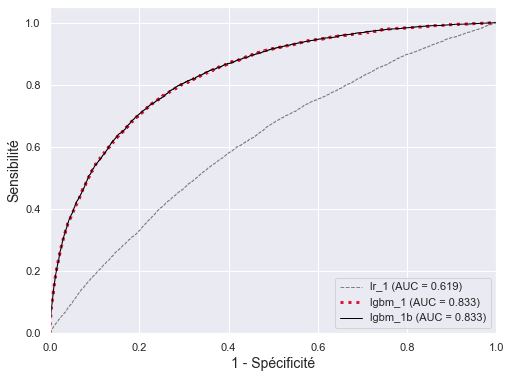

In [86]:
models_ = [lr_1, lgbm_1, lgbm_1]
model_names_ = ['lr_1', 'lgbm_1', 'lgbm_1b']

# Initialisation du dataframe d'évaluations
df_eval_all = pd.DataFrame({'Features dim':[],'Model':[],'Train score':[],'Test score':[],'Run time':[]})

for model_, model_name_ in zip(models_, model_names_) :
    submission, train_pred, test_pred, feat_imp, val_metrics, df_eval = cls_training(0, model_, model_name_,
                                                                                     features, labels, test_features)
    df_eval_all = pd.concat([df_eval_all, df_eval])
    df_eval_all.reset_index(drop=True,inplace=True)

roc_plot(strat_)
round((df_eval_all.sort_values('Test score', ascending=False)),3)

In [87]:
Markdown("""
>On obtient un score **AUC** équivalent en entraînant `LightGBM` sur le jeu de **{len_rfe}** variables.
""".format(len_rfe=len(feature_names_rfe)))


>On obtient un score **AUC** équivalent en entraînant `LightGBM` sur le jeu de **350** variables.


In [88]:
time_calc('Entraînement lgbm_1b - '+df_app_name,'195')
t = time.time()

Durée de l'opération 'Entraînement lgbm_1b - df_app_2': 1.48 s


## Optimisation des paramètres avec Hyperopt <a class="anchor" id="opt_par_hyp"></a>

Jusqu'ici nous avons testé les classifieurs avec leurs paramètres par défaut.

Nous avons retenu le classifieur `LightGBM` pour des raisons d'efficacité et de temps d'exécution.

On se propose maintenant d'optimiser ses paramètres. A ce stade, la complexité du modèle n'est pas favorable à une optimisation manuelle, cela prendrait beaucoup trop de temps. Les approches aléatoires ou par grille de recherche sont intéressantes mais peuvent également nécessiter beaucoup de temps avant d'arriver un résultat optimal, en particulier avec l'augmentation du nombre de paramètres à tester.

>On va alors utiliser une méthode d'optimisation basée sur l'inférence bayésienne. L'expérience a montré que cette aproche est plus efficace en terme de performances globales sur l'ensemble de test et de temps requis pour l'optimisation.
>
>Nous pouvons implémenter une méthode de ce type avec la librairie Python `Hyperopt`.

In [89]:
import hyperopt

### Jeu de données

In [90]:
x_train=features
y_train=labels

print('Dimensions features',features.shape)
print('Dimensions labels',labels.shape)
print('Dimensions test_features',test_features.shape)
print('dimensions test_labels',test_labels.shape)

Dimensions features (271398, 350)
Dimensions labels (271398,)
Dimensions test_features (61503, 350)
dimensions test_labels (61503,)


`Hyperopt` utilise une **fonction objectif** (objective function) pour l'optimisation des hyper-paramètres du classifieur.

>Le principe consiste à trouver les valeurs d'entrée (hyper-paramètres) de la fonction qui produisent la valeur de sortie la plus faible, appelée "perte" (loss).

`Hyperopt` construit un **modèle de probabilité** de la **fonction objectif** qui mappe les valeurs d'entrée à une probabilité de perte. Le modèle de probabilité est plus facile à optimiser que la fonction objectif, on parle de ***fonction de substitution***.

Le principe "bayésien" consiste alors à sélectionner les prochaines valeurs à tester en se basant sur un critère d'optimisation de la fonction de substitution. Cela permet de limiter les évaluations de la fonction objectif (gain de temps)

Contrairement aux méthodes aléatoires ou par grille, à chaque nouvelle itération, le raisonnement bayésien prend en compte les résultats de l'itération précédente et la fonction de substitution se rapproche de la fonction objectif.

>L'avantage de cette approche est qu'elle nous permet de définir la fonction objectif selon nos besoins. D'un point de vue purement technique, on va ainsi pouvoir demander à la fonction objective de maximiser la mesure **AUC** (ou autre mesure comme le F1-Score).

Optimiser la valeur de la mesure **AUC** permet d'améliorer globalement la **sensibilité** et la **spécificité**. Cette approche est pertinente si on considère les éléments de la matrice de confusion de même importance.

>Néanmoins, pour les organismes de crédit, un crédit non remboursé coûte plus cher qu'un dossier de crédit non signé. Il s'agit de trouver le meilleur compromis entre le nombre de crédit qu'on accorde mais qui ne seront in fine pas remboursés (les faux négatifs) et le nombre de crédit qu'on refuse et dont on perd potentiellement le bénéfice sur les intérêts pour les clients solvables (les faux positifs).

>On peut alors définir une **fonction de coût** en accordant des poids différents aux éléments de la matrice de confusion.

Nous pouvons par exemple affecter un poids de **-10** à chaque dossier prédit négatif mais réellement positif (**FN**) et un poids de **+1** aux dossiers négatifs identifiés comme tels (**TN**), les poids des dossiers **FP** et **TP** étant nuls.

Le gain résultant pour une valeur donnée du paramètre **seuil de classification** est alors défini par la fonction d’évaluation du gain suivante:

Gain = TP * (0) + TN * (1) + FP * (0) + FN * (-10)

### Fonction d'évaluation du gain <a class="anchor" id="fon_eva_gai"></a>

Nous définissons ci-dessous la **fonction d'évaluation du gain** avec comme données d'entrée les prédictions, les classes réelles, les poids des éléments de la matrice de confusion et en sortie le **gain normalisé**.

In [91]:
def g_norm_(y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1):

    g_norm_list = []
    # Matrice de Confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # gain total
    g = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    # gain maximum
    g_max = (fp + tn)*tn_value + (fn + tp)*tp_value
    # gain minimum
    g_min = (fp + tn)*fp_value + (fn + tp)*fn_value
    # gain normalisé
    g_norm = (g - g_min)/(g_max - g_min)

    return g_norm

### Modélisation Hyperopt <a class="anchor" id="mod_hyp"></a>

On définit la fonction **optim()** qui comprend:

**1)** La fonction objectif

**2)** L'espace des paramètres (Domain space) qui comprend les paramètres à tester avec leur gamme de valeurs

**3)** La méthode utilisée pour construire la fonction de substitution et choisir les prochaines valeurs à évaluer

**4)** La sauvegarde des résultats à chaque itération

In [92]:
import csv
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from hyperopt import STATUS_OK
from timeit import default_timer as timer

# Domain space
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

# Algorithme d'optimisation
from hyperopt import tpe

# Sauvegarde des résultats
from hyperopt import Trials

# Optimisation bayésienne
from hyperopt import fmin

skf = StratifiedKFold(n_splits=5)

def optim(hyperopt_processing_, # Option d'exécution (si 1: exécution, si 0: récupération des résultats sérialisés)
          eval_metric_, # Mesure d'évaluation
          method_):

    ### - 1 - Fonction objectif (objective function) ###
    
    def objective(params,
                  model = LGBMClassifier(),
                  x_train = features,
                  y_train = labels,
                  cv=skf,
                  eval_metric = eval_metric_):

        global ITERATION    
        ITERATION += 1

        # On s'assure que les paramètres soient au bon format
        for parameter_name in ['num_leaves','max_depth','n_estimators']:
            params[parameter_name] = int(params[parameter_name])

        # Paramètres du modèle    
        params_model = {'n_estimators': params['n_estimators'], 
                        'class_weight': params['class_weight'],
                        'max_depth': int(params['max_depth']), 
                        'learning_rate': params['learning_rate'],
                        'subsample': params['subsample'],
                        'colsample_bytree': params['colsample_bytree'],
                        'num_leaves': int(params['num_leaves']),
                        'reg_alpha': params['reg_alpha'],
                        'reg_lambda': params['reg_lambda']
                       }

        model.set_params(**params_model)

        start = timer()

        # Seuil de classification
        threshold = params['solvability_threshold']

        if method_ == 1:
            y_proba = cross_val_predict(model,
                                        x_train,
                                        y_train,
                                        method='predict_proba',
                                        cv=skf)[:, 1]
        
            # Si proba > seuil alors la prédiction est positive : 1
            y_pred = (y_proba > threshold)
            y_pred = np.array(y_pred > 0) * 1
        
        elif method_ == 2:
            y_pred = cross_val_predict(model,
                                       x_train,
                                       y_train,
                                       method='predict',
                                       cv=skf)
            
        # Calcul du score suivant la métrique utilisé
        score = eval_metric(y_train, y_pred)
            
        # Minimisation du loss
        loss = 1 - score

        run_time = round((timer() - start),0)

        # Export fichier csv
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow([loss, params, ITERATION, run_time])

        return {'loss': loss, 'params': params, 'iteration': ITERATION, 
                'train_time': run_time, 'status': STATUS_OK}

    ### - 2 - Dictionnaire des paramètres (Domain space) ###
    
    space = {'n_estimators': hp.quniform('n_estimators', 200, 800, 200),
             'class_weight': hp.choice('class_weight', [None, 'balanced']),
             'max_depth' : hp.quniform('max_depth', 2, 30, 2),
             'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
             'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
             'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
             'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
             'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
             'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
             'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
            }

    ### - 3 - Algorithme d'optimisation (fonction de substitution)
    tpe_algorithm = tpe.suggest

    ### - 4 - Sauvegarde des résultats
    bayes_trials = Trials()

    # Fichier de sauvegarde des résultats
    out_file = '../OC_DS_P7/hyperopt/'+df_app_name+'_gbm_trials.csv'
    of_connection = open(out_file, 'w')
    writer = csv.writer(of_connection)

    # En-têtes du fichier
    writer.writerow(['loss', 'params', 'iteration', 'train_time'])
    of_connection.close()

    if eval_metric_ == g_norm_:
        metric_ = 'GainNorm'
    elif eval_metric_ == roc_auc_score:
        metric_ = 'RocAuc'
    elif eval_metric_ == f1_score:
        metric_ = 'F1Sco'
    
    if hyperopt_processing_ == 1:

        global  ITERATION
        ITERATION = 0
        MAX_EVALS = max_evals_

        best = fmin(fn = objective,
                    space = space,
                    algo = tpe.suggest,
                    max_evals = MAX_EVALS,
                    trials = bayes_trials,
#                     rstate = np.random.RandomState(rs_)
                   )

        results = pd.read_csv('../OC_DS_P7/hyperopt/'+df_app_name+'_gbm_trials.csv')
        joblib.dump(results, '../OC_DS_P7/hyperopt/'+df_app_name+'_'+metric_+'_results.joblib')

    elif hyperopt_processing_ == 0:

        results = joblib.load('../OC_DS_P7/hyperopt/'+df_app_name+'_'+metric_+'_results.joblib')

    return results

In [93]:
import ast

In [94]:
def results_hyperopt(results):
    
    results.sort_values('loss', ascending = True, inplace = True)
    results.reset_index(inplace = True, drop = True)

    sol_thr_list = []
    n_estimators_list = []
    class_weight_list = []
    for i in results.index:
        sol_thr_list.append(ast.literal_eval(results.loc[i, 'params'])['solvability_threshold'])
        n_estimators_list.append(ast.literal_eval(results.loc[i, 'params'])['n_estimators'])
        class_weight_list.append(ast.literal_eval(results.loc[i, 'params'])['class_weight'])
    results['threshold'] = sol_thr_list
    results['n_estimator'] = n_estimators_list
    results['class_weight'] = class_weight_list

    return round(results[['loss','threshold','n_estimator','class_weight','iteration','train_time']],4)

### Résultats

On exécute la fonction **optim()** avec des critères d'évaluation techniques (**AUC** et **F1-Score**) puis avec le critère *métier* (**maximisation du gain**).

In [95]:
results_auc_score = optim(r_, roc_auc_score, 1)
results_hyperopt(results_auc_score).head()

loss  threshold  n_estimator class_weight  iteration  train_time
0  0.1763      0.200          400         None         13       625.0
1  0.1788      0.225          800         None          3       336.0
2  0.1874      0.100          800         None          5      1020.0
3  0.1874      0.300          400         None          8       340.0
4  0.1921      0.250          800     balanced         19       565.0

In [96]:
results_f1_score = optim(r_, f1_score, 1)
results_hyperopt(results_f1_score).head()

loss  threshold  n_estimator class_weight  iteration  train_time
0  0.2699      0.450          400         None         18       541.0
1  0.2843      0.825          400         None          3       391.0
2  0.2920      0.850          200         None          7       328.0
3  0.3015      0.550          800     balanced          4      1089.0
4  0.3166      0.525          600     balanced          1       594.0

In [97]:
results_g_norm = optim(r_, g_norm_, 1)
results_hyperopt(results_g_norm).head()

loss  threshold  n_estimator class_weight  iteration  train_time
0  0.1919      0.425          600     balanced         20       990.0
1  0.1939      0.275          600     balanced         13       336.0
2  0.2021      0.175          600         None         14       360.0
3  0.2080      0.075          400     balanced         10       490.0
4  0.2163      0.500          400     balanced          5       518.0

In [98]:
time_calc('Optimisation hyperopt - '+df_app_name,'34414')
t = time.time()

Durée de l'opération 'Optimisation hyperopt - df_app_2': 1.23 s


## Entraînement LightGBM optimisé <a class="anchor" id="ent_lgb_opt"></a>

Nous disposons à ce stade de 3 modèles `LightGBM` dont les paramètres ont été optimisés suivant des critères techniques ou métier.

### Paramètres optimisés <a class="anchor" id="par_opt"></a>

In [99]:
# Meilleurs paramètres (auc_score)
best_bayes_params_auc_score = ast.literal_eval(results_auc_score.loc[0, 'params']).copy()
best_bayes_params_auc_score

{'class_weight': None,
 'colsample_bytree': 0.7000000000000001,
 'learning_rate': 0.02733835159616305,
 'max_depth': 10,
 'n_estimators': 400,
 'num_leaves': 88,
 'reg_alpha': 0.5,
 'reg_lambda': 0.1,
 'solvability_threshold': 0.2,
 'subsample': 1.0}

In [100]:
# Meilleurs paramètres (f1_score)
best_bayes_params_f1_score = ast.literal_eval(results_f1_score.loc[0, 'params']).copy()
best_bayes_params_f1_score

{'class_weight': None,
 'colsample_bytree': 0.8,
 'learning_rate': 0.03293375346034255,
 'max_depth': 20,
 'n_estimators': 400,
 'num_leaves': 44,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'solvability_threshold': 0.45,
 'subsample': 1.0}

In [101]:
# Meilleurs paramètres (g_norm)
best_bayes_params_g_norm = ast.literal_eval(results_g_norm.loc[0, 'params']).copy()
best_bayes_params_g_norm

{'class_weight': 'balanced',
 'colsample_bytree': 0.8,
 'learning_rate': 0.0207747487935626,
 'max_depth': 18,
 'n_estimators': 600,
 'num_leaves': 76,
 'reg_alpha': 1.0,
 'reg_lambda': 0.30000000000000004,
 'solvability_threshold': 0.42500000000000004,
 'subsample': 0.8}

Le **seuil de classification** n'est pas un hyper-paramètre du classifieur. Il est exploité une fois que les prédictions (sous forme de probabilité) aient été produites à l'issue de l'entraînement. Il permet alors de déterminer les prédictions binaires utiles pour la construction de la matrice de confusion dont les éléments servent à définir la mesure à optimiser (AUC ou gain).

Il fait donc partie des paramètres de la fonction objectif à optimiser.

Ci-dessous les seuils de classification optimaux obtenus dans les 3 cas.

In [102]:
solvability_threshold_auc_score = best_bayes_params_auc_score['solvability_threshold']
round(solvability_threshold_auc_score,3)

0.2

In [103]:
solvability_threshold_f1_score = best_bayes_params_f1_score['solvability_threshold']
round(solvability_threshold_f1_score,3)

0.45

In [104]:
solvability_threshold_g_norm = best_bayes_params_g_norm['solvability_threshold']
round(solvability_threshold_g_norm,3)

0.425

In [105]:
metric_ = 'GainNorm'
joblib.dump(solvability_threshold_g_norm, '../OC_DS_P7/hyperopt/'+df_app_name+'_'+metric_+'_threshold_g_norm.joblib')

['../OC_DS_P7/hyperopt/df_app_2_GainNorm_threshold_g_norm.joblib']

In [106]:
del best_bayes_params_g_norm['solvability_threshold']
del best_bayes_params_auc_score['solvability_threshold']
del best_bayes_params_f1_score['solvability_threshold']

Nous entraînons à nouveau `LightGBM` avec les trois configurations de paramètres obtenues avec `Hyperopt`.

Nous définissons ci-dessous une fonction pour l'entraînement du classifieur et la présentation des résultats utiles à l'analyse.

In [107]:
def scoring_results(clf_, clf_version_, test_labels, solvability_threshold_):
    
    # Entraînement du modèle
    submission, train_pred, test_pred, feat_imp, val_metrics, df_eval = cls_training(r_, clf_, clf_version_,
                                                                                     features, labels, test_features)

    # Comparaison des scores avec les autres classifieurs
    models_.append(clf_)
    model_names_.append(clf_version_)

    # Initialisation du dataframe d'évaluations
    df_eval_all = pd.DataFrame({'Features dim':[],'Model':[],'Train score':[],'Test score':[],'Run time':[]})

    for model_, model_name_ in zip(models_, model_names_) :
        submission, train_pred, test_pred, feat_imp, val_metrics, df_eval = cls_training(0, model_, model_name_,
                                                                                         features, labels, test_features)
        df_eval_all = pd.concat([df_eval_all, df_eval])
        df_eval_all.reset_index(drop=True,inplace=True)

    scores = round((df_eval_all.sort_values('Test score', ascending=False)),3)
    
    # Courbes ROC
    plt.figure(figsize=(8,6))
    # Initialisation de la liste des étiquettes pour la légende
    model_auc_ = []
    
    for model_name_ in model_names_:    
        [fpr, tpr, thr] = joblib.load(path_results+df_app_name+'_'+strat_+'_'+model_name_+'_fpr_tpr_thr.joblib')
        # Calcul de la mesure AUC
        auc = round(metrics.auc(fpr, tpr),3)
        # Etiquette
        model_auc = model_name_+' (AUC = '+str(auc)+')'
        # Ajout de l'étiquette à la liste
        model_auc_.append(model_auc)

        plt.plot(fpr, tpr,
                 color=df_cls_att.loc[model_name_,'color_code'],
                 label=model_name_,
                 lw=df_cls_att.loc[model_name_,'line_width'],
                 ls=df_cls_att.loc[model_name_,'line_style'])
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Spécificité', fontsize=14)
    plt.ylabel('Sensibilité', fontsize=14)
    plt.legend(model_auc_, loc="lower right");
    plt.show();
    
    
    [fpr, tpr, thr] = metrics.roc_curve(test_labels, test_pred)
    n = solvability_threshold_ # seuil optimal
    idx = np.max(np.where(thr > n)) # indice du seuil pour lequel la sensibilité est supérieure à n
    
    title = 'Courbe ROC'
    print('\n'+title)
    print('-'*len(title))
    
    plt.plot(fpr, tpr, color='coral', lw=2)

    plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], color='#318CE7', lw=2)
    plt.plot([fpr[idx], fpr[idx]], [tpr[idx], 0], color='#318CE7', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Spécificité', fontsize=14)
    plt.ylabel('Sensibilité', fontsize=14)
    plt.show();

    print('\nAUC =',round(metrics.auc(fpr, tpr),3))
    print ('\nSeuil optimal:',round(solvability_threshold_,3))
    print ('Sensibilité : %.3f' % tpr[idx])
    print ('1 - Spécificité : %.3f' % (fpr[idx]))
    print ('Spécificité : %.3f' % (1-fpr[idx]))
    
    # On définit le df scoring comme les résultats des prédictions probas sur le jeu de test
    # Rappelons qu'il s'agit d'une moyenne obtenue après entraînement par validation croisée (5 modèles)
    scoring = pd.DataFrame(test_ids).reset_index(drop=True).merge(pd.DataFrame(test_pred), left_index=True, right_index=True)
    scoring.columns = ['SK_ID_CURR','Credit_Score']

    # On filtre les lignes pour lesquelles le credit_score est supérieur au seuil
    # La prédiction est donc 1 (crédit non remboursé)
    scoring_1 = scoring[scoring['Credit_Score'] > solvability_threshold_]
    scoring_1['Credit_Pred'] = 1

    # On filtre les lignes pour lesquelles le credit_score est inférieur ou égal au seuil
    # La prédiction est donc 0 (crédit remboursé)
    scoring_0 = scoring[scoring['Credit_Score'] <= solvability_threshold_]
    scoring_0['Credit_Pred'] = 0

    scoring = pd.concat([scoring_1,scoring_0])

    test_true = pd.DataFrame(test_labels).reset_index(drop=True)

    #scoring_vs_true
    scoring_vs_true = scoring.merge(test_true, left_index=True, right_index=True)
    scoring_vs_true = scoring_vs_true.sort_index()
    
    x_pred = scoring_vs_true['Credit_Pred']
    y_true = scoring_vs_true['TARGET']

    tn, fp, fn, tp = confusion_matrix(y_true, x_pred).ravel()
    (tn, fp, fn, tp)

    # Matrice de Confusion
    cfm = confusion_matrix(y_true, x_pred)

    tn = cfm[0, 0]
    fn = cfm[1, 0]
    fp = cfm[0, 1]
    tp = cfm[1, 1]
    
    print('Précision =',round((tp/(tp+fp)),3))
    print('F-Mesure =',round((2*tp/((2*tp)+fn+fp)),3))
    
    # Calcul de l'accuracy
    scoring_vs_true['Eval'] = scoring_vs_true['Credit_Pred'] - scoring_vs_true['TARGET']
    # Pourcentage de valeurs correctement prédites
    print('Accuracy =',round((len(scoring_vs_true[scoring_vs_true['Eval'] == 0]) / scoring_vs_true.shape[0]),3))
    
    title = 'Matrice de confusion'
    print('\n'+title)
    print('-'*len(title))
    print('\ntn :',tn)
    print('fn:',fn)
    print('fp :',fp)
    print('tp:',tp)
    
    df_cfm = pd.DataFrame(cfm).T
    df_cfm.columns = ['Solvable (0)','Non solvable (1)']
    df_cfm['Prédiction'] = [0,1]
    df_cfm = df_cfm.set_index('Prédiction')

    sns.heatmap(df_cfm, cmap="YlGnBu", annot=True, fmt="d");
    
    return scores, test_pred

### LightGBM optimisé (roc_auc_score) <a class="anchor" id="lgb_opt_auc"></a>

In [108]:
lgbm_version_ = 'lgbm_2'

lgbm_2 = LGBMClassifier(objective = 'binary',
                        n_jobs = -1,
                        random_state = rs_,
                        **best_bayes_params_auc_score)
lgbm_2.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7000000000000001,
 'importance_type': 'split',
 'learning_rate': 0.02733835159616305,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 400,
 'n_jobs': -1,
 'num_leaves': 88,
 'objective': 'binary',
 'random_state': 45,
 'reg_alpha': 0.5,
 'reg_lambda': 0.1,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [109]:
models_ = [lr_1, lgbm_1]
model_names_ = ['lr_1', 'lgbm_1b']

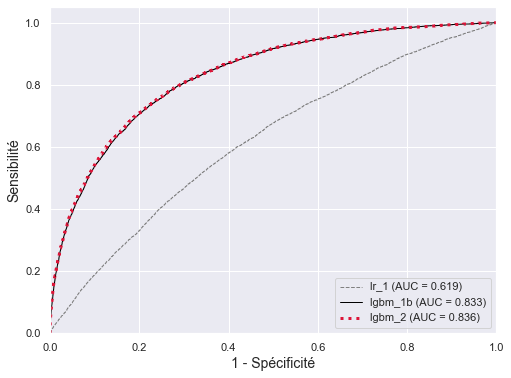


Courbe ROC
----------


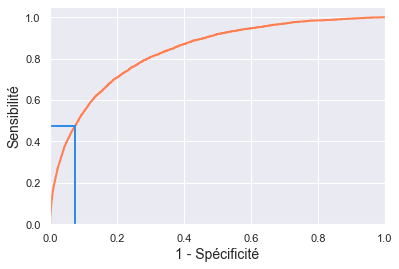


AUC = 0.836

Seuil optimal: 0.2
Sensibilité : 0.473
1 - Spécificité : 0.074
Spécificité : 0.926
Précision = 0.362
F-Mesure = 0.41
Accuracy = 0.89

Matrice de confusion
--------------------

tn : 52359
fn: 2625
fp : 4162
tp: 2357


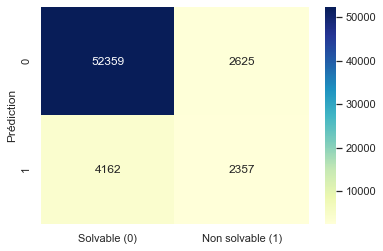

In [110]:
scores, test_pred = scoring_results(lgbm_2,'lgbm_2',test_labels,solvability_threshold_auc_score)

In [111]:
scores

Features dim    Model  Train score  Test score  Run time
2  (271398, 350)   lgbm_2        0.959       0.836     658.0
1  (271398, 350)  lgbm_1b        0.936       0.833     194.0
0  (271398, 897)     lr_1        0.631       0.619     143.0

In [112]:
time_calc('Entraînement lgbm_2 (auc_score) - '+df_app_name,'660')
t = time.time()

Durée de l'opération 'Entraînement lgbm_2 (auc_score) - df_app_2': 1.32 s


### LightGBM optimisé (f1_score) <a class="anchor" id="lgb_opt_f1s"></a>

In [113]:
lgbm_version_ = 'lgbm_2b'

lgbm_2b = LGBMClassifier(objective = 'binary',
                        n_jobs = -1,
                        random_state = rs_,
                        **best_bayes_params_f1_score)
lgbm_2b.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.03293375346034255,
 'max_depth': 20,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 400,
 'n_jobs': -1,
 'num_leaves': 44,
 'objective': 'binary',
 'random_state': 45,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [114]:
models_ = [lr_1, lgbm_2]
model_names_ = ['lr_1', 'lgbm_2']

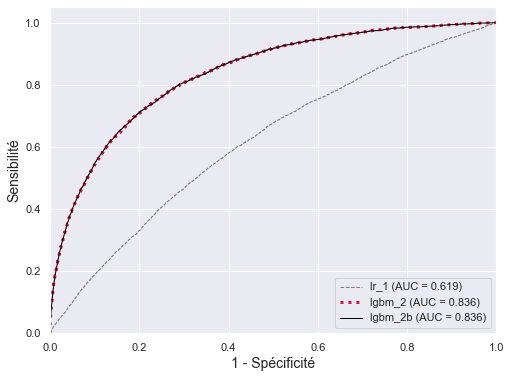


Courbe ROC
----------


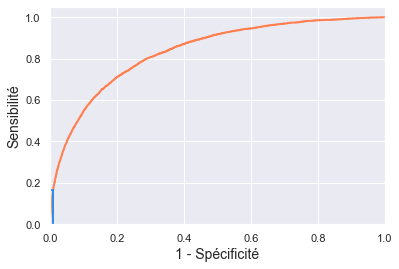


AUC = 0.836

Seuil optimal: 0.45
Sensibilité : 0.164
1 - Spécificité : 0.009
Spécificité : 0.991
Précision = 0.615
F-Mesure = 0.26
Accuracy = 0.924

Matrice de confusion
--------------------

tn : 56008
fn: 4162
fp : 513
tp: 820


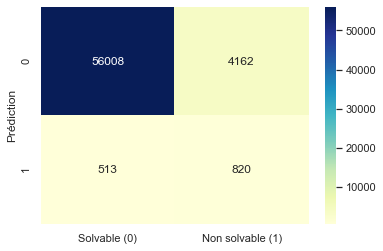

In [115]:
scores, test_pred = scoring_results(lgbm_2b,'lgbm_2b',test_labels,solvability_threshold_f1_score)

In [116]:
scores

Features dim    Model  Train score  Test score  Run time
2  (271398, 350)  lgbm_2b        0.947       0.836     574.0
1  (271398, 350)   lgbm_2        0.959       0.836     658.0
0  (271398, 897)     lr_1        0.631       0.619     143.0

In [117]:
time_calc('Entraînement lgbm_2 (f1_score) - '+df_app_name,'576')
t = time.time()

Durée de l'opération 'Entraînement lgbm_2 (f1_score) - df_app_2': 1.13 s


### LightGBM optimisé (gain) <a class="anchor" id="lgb_opt_gai"></a>

In [118]:
lgbm_version_ = 'lgbm_3'

lgbm_3 = LGBMClassifier(objective = 'binary',
                        n_jobs = -1,
                        random_state = rs_,
                        **best_bayes_params_g_norm)
lgbm_3.get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.0207747487935626,
 'max_depth': 18,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 600,
 'n_jobs': -1,
 'num_leaves': 76,
 'objective': 'binary',
 'random_state': 45,
 'reg_alpha': 1.0,
 'reg_lambda': 0.30000000000000004,
 'silent': True,
 'subsample': 0.8,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [119]:
models_ = [lr_1, lgbm_2]
model_names_ = ['lr_1', 'lgbm_2']

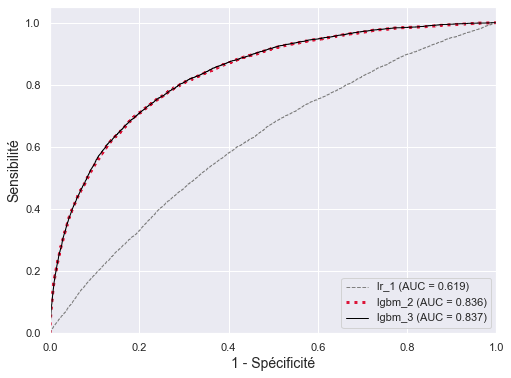


Courbe ROC
----------


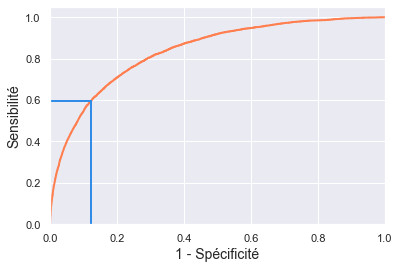


AUC = 0.837

Seuil optimal: 0.425
Sensibilité : 0.597
1 - Spécificité : 0.123
Spécificité : 0.877
Précision = 0.3
F-Mesure = 0.399
Accuracy = 0.854

Matrice de confusion
--------------------

tn : 49565
fn: 2007
fp : 6956
tp: 2975


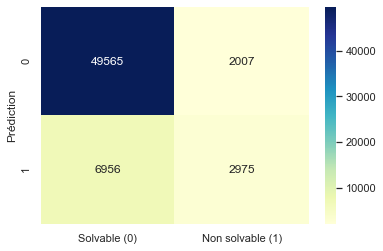

In [120]:
scores, test_pred = scoring_results(lgbm_3,'lgbm_3',test_labels,solvability_threshold_g_norm)

In [121]:
time_calc('Entraînement lgbm_3 (gain) - '+df_app_name,'1175')
t = time.time()

Durée de l'opération 'Entraînement lgbm_3 (gain) - df_app_2': 1.09 s


### Tableau comparatif des scores <a class="anchor" id="tab_com_sco"></a>

In [122]:
models_ = [lr_1, rf_1, xgb_1, catb_1, lgbm_1, lgbm_1, lgbm_2, lgbm_2b, lgbm_3]
model_names_ = ['lr_1', 'rf_1', 'xgb_1', 'catb_1', 'lgbm_1', 'lgbm_1b', 'lgbm_2', 'lgbm_2b', 'lgbm_3']

In [123]:
# Initialisation du dataframe d'évaluations
df_eval_all = pd.DataFrame({'Features dim':[],'Model':[],'Train score':[],'Test score':[],'Run time':[]})

for model_, model_name_ in zip(models_, model_names_) :
    submission, train_pred, test_pred, feat_imp, val_metrics, df_eval = cls_training(0, model_, model_name_,
                                                                                     features, labels, test_features)
    df_eval_all = pd.concat([df_eval_all, df_eval])
    df_eval_all.reset_index(drop=True,inplace=True)

scores = round((df_eval_all.sort_values('Test score', ascending=False)),3)
scores

Features dim    Model  Train score  Test score  Run time
8  (271398, 350)   lgbm_3        0.961       0.837    1173.0
7  (271398, 350)  lgbm_2b        0.947       0.836     574.0
6  (271398, 350)   lgbm_2        0.959       0.836     658.0
2  (271398, 897)    xgb_1        0.955       0.834    3934.0
5  (271398, 350)  lgbm_1b        0.936       0.833     194.0
4  (271398, 897)   lgbm_1        0.936       0.833     354.0
3  (271398, 897)   catb_1        0.942       0.831    2499.0
1  (271398, 897)     rf_1        1.000       0.790     971.0
0  (271398, 897)     lr_1        0.631       0.619     143.0

In [124]:
# Dernière version de test_pred
print('test_pred:',test_pred)
print('\ntest_labels:')
print('')
print(test_labels)
[fpr, tpr, thr] = metrics.roc_curve(test_labels, test_pred)
print('\nAUC =',round(metrics.auc(fpr, tpr),3))

test_pred: [0.05204332 0.12076175 0.19065813 ... 0.91561083 0.07718622 0.07105562]

test_labels:

179042    0
269683    0
42405     0
228527    0
47854     0
         ..
188958    0
257567    0
169836    1
98283     0
99919     0
Name: TARGET, Length: 61503, dtype: int64

AUC = 0.837


In [125]:
joblib.dump(test_pred, '../OC_DS_P7/features_app/test_pred.joblib')

['../OC_DS_P7/features_app/test_pred.joblib']

### Evolution du gain (données de test) <a class="anchor" id="evo_gai"></a>

On créé une fonction d'**évolution du gain** en fonction du **seuil de classification**.

In [126]:
def g_norm_2(y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1):

    g_norm_list = []
    # Matrice de Confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # gain total
    g = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    # gain maximum
    g_max = (fp + tn)*tn_value + (fn + tp)*tp_value
    # gain minimum
    g_min = (fp + tn)*fp_value + (fn + tp)*fn_value
    # gain normalisé
    g_norm = (g - g_min)/(g_max - g_min)
    
    g_norm_list.append(tn)
    g_norm_list.append(fp)
    g_norm_list.append(fn)
    g_norm_list.append(tp)
    g_norm_list.append(g)
    g_norm_list.append(g_max)
    g_norm_list.append(g_min)
    g_norm_list.append(g - g_min)
    g_norm_list.append(g_max - g_min)
    g_norm_list.append(g_norm)

    return g_norm_list

In [127]:
def gain_seuil(y_set, x_set, lgbm_version_='lgbm_3', incr_=500):
    
    """
    Evolution du gain en fonction du seuil de classification fixé
    Si score < seuil : crédit remboursé
    Sinon : client non solvable
    
    """
    
    print('Process is running...')
    
    if lgbm_version_ == 'lgbm_3':
        threshold_x = np.linspace(0.0, 1, incr_)
    elif lgbm_version_ == 'lgbm_2':
        threshold_x = [solvability_threshold_auc_score]
    elif lgbm_version_ == 'lgbm_2b':
        threshold_x = [solvability_threshold_f1_score]
    
    kf_list = [1, 2, 3, 4, 5]
    print('Folds =',len(kf_list))
    
    # Initialisation du dataframe
    df_g_norm = np.zeros(10)
    
    for kf in kf_list:
        
        clf = joblib.load(path_models+df_app_name+'_'+strat_+'_'+lgbm_version_+'_'+str(kf)+'.joblib')
        print('CV Step:',kf)
        
        g_norm_list_all = []
        
        for threshold in threshold_x:

            # Score du modèle : 0 à 1
            y_scores = clf.predict_proba(x_set)[:, 1]

            # Score > seuil de classification : retourne 1 sinon 0
            y_pred = (y_scores > threshold)
            y_pred = np.array(y_pred > 0) * 1

            # Calcul du gain
            g_norm_list = g_norm_2(y_set, y_pred)      
            g_norm_list_all.append(g_norm_list)
            
        df_g_norm_k = pd.DataFrame(g_norm_list_all)
        print('Gain =',round((df_g_norm_k[9].max()),4))
    
        df_g_norm = df_g_norm + df_g_norm_k

    df_g_norm = df_g_norm / len(kf_list)
    
    df_g_norm['threshold'] = threshold_x
    df_g_norm.columns = ['tn','fp','fn','tp','g','g_max','g_min','g - g_min','g_max - g_min','g_norm','seuil']
    df_g_norm = df_g_norm.sort_values('seuil',ascending=False)
    
    print('End of process')
    
    return df_g_norm

On utilise la fonction d'évolution du gain pour calculer le gain optimal obtenu avec le classifieur optimisé **roc_auc_score**.

In [128]:
df_auc_test = gain_seuil(test_labels, test_features, 'lgbm_2')
df_auc_test[['g_norm','seuil']]

Process is running...
Folds = 5
CV Step: 1
Gain = 0.7122
CV Step: 2
Gain = 0.7124
CV Step: 3
Gain = 0.712
CV Step: 4
Gain = 0.7157
CV Step: 5
Gain = 0.7137
End of process


g_norm  seuil
0  0.713206    0.2

On utilise la fonction d'évolution du gain pour calculer le gain optimal obtenu avec le classifieur optimisé **F1_score**.

In [129]:
df_f1_test = gain_seuil(test_labels, test_features, 'lgbm_2b')
df_f1_test[['g_norm','seuil']]

Process is running...
Folds = 5
CV Step: 1
Gain = 0.6034
CV Step: 2
Gain = 0.6024
CV Step: 3
Gain = 0.6041
CV Step: 4
Gain = 0.6044
CV Step: 5
Gain = 0.603
End of process


g_norm  seuil
0  0.603453   0.45

Concernant le classifieur optimisé selon les règles métier, nous calculons un certains nombre de valeurs pour le couple gain/seuil en vue de créer un graphe de l'évolution du gain en fonction du seuil.

In [130]:
lgbm_version_ = 'lgbm_3'

In [131]:
df_g_norm_ = r_

if df_g_norm_ == 1:
    df_g_norm_test = gain_seuil(test_labels, test_features)
    joblib.dump(df_g_norm_test, path_results+df_app_name+'_'+strat_+'_'+lgbm_version_+'_df_g_norm_test.joblib')
    
elif df_g_norm_ == 0:
    df_g_norm_test = joblib.load(path_results+df_app_name+'_'+strat_+'_'+lgbm_version_+'_df_g_norm_test.joblib')

In [132]:
df_g_norm_test.sort_values(['g_norm','seuil'], ascending=[False,False]).head()

tn       fp      fn      tp        g    g_max    g_min  g - g_min  \
156  44725.8  11795.2  1411.4  3570.6  30611.8  56521.0 -49820.0    80431.8   
153  44401.2  12119.8  1379.6  3602.4  30605.2  56521.0 -49820.0    80425.2   
155  44618.6  11902.4  1402.0  3580.0  30598.6  56521.0 -49820.0    80418.6   
154  44508.6  12012.4  1391.4  3590.6  30594.6  56521.0 -49820.0    80414.6   
152  44295.8  12225.2  1370.8  3611.2  30587.8  56521.0 -49820.0    80407.8   

     g_max - g_min    g_norm     seuil  
156       106341.0  0.756357  0.312625  
153       106341.0  0.756295  0.306613  
155       106341.0  0.756233  0.310621  
154       106341.0  0.756196  0.308617  
152       106341.0  0.756132  0.304609

In [133]:
solvability_threshold_g_norm_adj = df_g_norm_test[['g_norm','seuil']].sort_values('g_norm',ascending=False).iloc[0,1]
solvability_threshold_g_norm_adj = round(solvability_threshold_g_norm_adj,4)
solvability_threshold_g_norm_adj

0.3126

In [134]:
Markdown("""
On constate que le seuil relatif au gain optimal dans la fonction d'évolution du gain
(seuil = **{seuil_2}**) est légèrement différent de celui obtenue à l'issue du processus Hypertopt
(seuil = **{seuil_1}**).
""".format(seuil_1=round(solvability_threshold_g_norm,4),seuil_2=solvability_threshold_g_norm_adj))


On constate que le seuil relatif au gain optimal dans la fonction d'évolution du gain
(seuil = **0.3126**) est légèrement différent de celui obtenue à l'issue du processus Hypertopt
(seuil = **0.425**).


Cela est due au nombre d'itérations effectuées lors de l'optimisation `Hyperopt` ainsi qu'à la
gamme de valeurs du paramètre **seuil de classification**.
On peut améliorer les résultats en augmentant ces critères mais au prix d'un temps d'exécution supérieur.  

On retiendra comme seuil optimal la valeur issue de la fonction d'évolution.

Evolution du gain en fonction du seuil (données de test)
--------------------------------------------------------


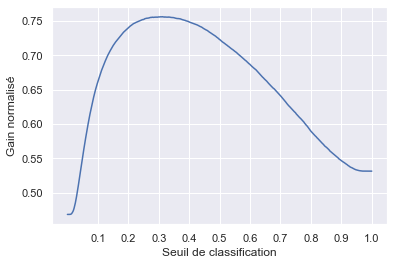

In [135]:
title = 'Evolution du gain en fonction du seuil (données de test)'
print(title)
print('-'*len(title))
plt.plot(df_g_norm_test['seuil'], df_g_norm_test['g_norm'])
plt.xlabel("Seuil de classification")
plt.ylabel("Gain normalisé")
plt.xticks(np.linspace(0.1, 1, 10));

### Evolution des indicateurs ROC <a class="anchor" id="evo_ind_roc"></a>

In [136]:
df_g_norm_test['sensibilité'] = df_g_norm_test['tp'] / (df_g_norm_test['tp'] + df_g_norm_test['fn'])
df_g_norm_test['spécificité'] = df_g_norm_test['tn'] / (df_g_norm_test['tn'] + df_g_norm_test['fp'])
df_g_norm_test['précision'] = df_g_norm_test['tp'] / (df_g_norm_test['tp'] + df_g_norm_test['fp'])
df_g_norm_test['f1'] = 2 * df_g_norm_test['tp'] / ((2 * df_g_norm_test['tp']) + df_g_norm_test['fp'] + df_g_norm_test['fn'])
df_g_norm_test.head()

tn   fp      fn   tp       g    g_max    g_min  g - g_min  \
499  56521.0  0.0  4982.0  0.0  6701.0  56521.0 -49820.0    56521.0   
498  56521.0  0.0  4982.0  0.0  6701.0  56521.0 -49820.0    56521.0   
497  56521.0  0.0  4982.0  0.0  6701.0  56521.0 -49820.0    56521.0   
496  56521.0  0.0  4982.0  0.0  6701.0  56521.0 -49820.0    56521.0   
495  56521.0  0.0  4982.0  0.0  6701.0  56521.0 -49820.0    56521.0   

     g_max - g_min    g_norm     seuil  sensibilité  spécificité  précision  \
499       106341.0  0.531507  1.000000          0.0          1.0        NaN   
498       106341.0  0.531507  0.997996          0.0          1.0        NaN   
497       106341.0  0.531507  0.995992          0.0          1.0        NaN   
496       106341.0  0.531507  0.993988          0.0          1.0        NaN   
495       106341.0  0.531507  0.991984          0.0          1.0        NaN   

      f1  
499  0.0  
498  0.0  
497  0.0  
496  0.0  
495  0.0

In [137]:
gain_opt_id = df_g_norm_test.sort_values('g_norm',ascending=False).iloc[0:1].index[0]
seuil_opt = pd.DataFrame({0:[gain_opt_id,gain_opt_id],1:[0,1]})
seuil_opt = seuil_opt.set_index(0)

Evolution des indicateurs ROC (1)
---------------------------------


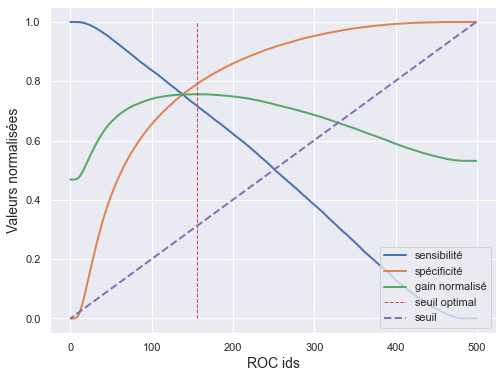

In [138]:
title = 'Evolution des indicateurs ROC (1)'
print(title)
print('-'*len(title))
plt.figure(figsize=(8,6))
plt.plot(df_g_norm_test[['sensibilité','spécificité','g_norm']], lw=2)
plt.plot(seuil_opt, lw=1, ls='--')
plt.plot(df_g_norm_test[['seuil']], lw=2, ls='--')
plt.xlabel('ROC ids', fontsize=14)
plt.ylabel('Valeurs normalisées', fontsize=14)
plt.legend(['sensibilité','spécificité','gain normalisé','seuil optimal','seuil'], loc="lower right");
plt.show();

Evolution des indicateurs ROC (2)
---------------------------------


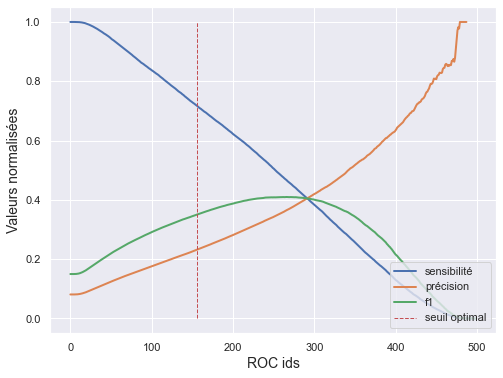

In [139]:
title = 'Evolution des indicateurs ROC (2)'
print(title)
print('-'*len(title))
plt.figure(figsize=(8,6))
plt.plot(df_g_norm_test[['sensibilité','précision','f1']], lw=2)
plt.plot(seuil_opt, lw=1, ls='--')
plt.xlabel('ROC ids', fontsize=14)
plt.ylabel('Valeurs normalisées', fontsize=14)
plt.legend(['sensibilité','précision','f1','seuil optimal'], loc="lower right");
plt.show();

### Evolution du gain (données d'entraînement) <a class="anchor" id="evo_gai_ent"></a>

In [140]:
if df_g_norm_ == 1:
    df_g_norm_train = gain_seuil(labels, features, 'lgbm_3', 50)
    joblib.dump(df_g_norm_train, path_results+df_app_name+'_'+strat_+'_'+lgbm_version_+'_df_g_norm_train.joblib')
    
elif df_g_norm_ == 0:
    df_g_norm_train = joblib.load(path_results+df_app_name+'_'+strat_+'_'+lgbm_version_+'_df_g_norm_train.joblib')

In [141]:
joblib.dump(df_g_norm_train, path_results+df_app_name+'_'+strat_+'_'+lgbm_version_+'_df_g_norm_train.joblib')

['../OC_DS_P7/results/df_app_2_1_lgbm_3_df_g_norm_train.joblib']

In [142]:
round((df_g_norm_train.sort_values(['g_norm','seuil'], ascending=[False,False])),2).head()

tn       fp      fn       tp         g     g_max     g_min  \
16  184291.4  41873.6  3306.2  41926.8  151229.4  226165.0 -452330.0   
17  188110.6  38054.4  3704.2  41528.8  151068.6  226165.0 -452330.0   
15  180183.4  45981.6  2912.8  42320.2  151055.4  226165.0 -452330.0   
14  175666.4  50498.6  2548.4  42684.6  150182.4  226165.0 -452330.0   
18  191529.0  34636.0  4140.0  41093.0  150129.0  226165.0 -452330.0   

    g - g_min  g_max - g_min  g_norm  seuil  
16   603559.4       678495.0    0.89   0.33  
17   603398.6       678495.0    0.89   0.35  
15   603385.4       678495.0    0.89   0.31  
14   602512.4       678495.0    0.89   0.29  
18   602459.0       678495.0    0.89   0.37

Evolution du gain en fonction du seuil (données d'entrainement)
---------------------------------------------------------------


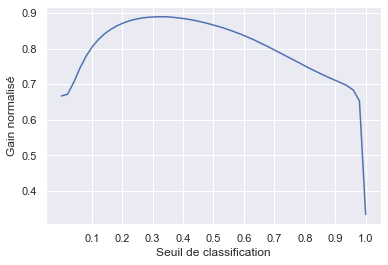

In [143]:
title = 'Evolution du gain en fonction du seuil (données d\'entrainement)'
print(title)
print('-'*len(title))
plt.plot(df_g_norm_train['seuil'], df_g_norm_train['g_norm'])
plt.xlabel("Seuil de classification")
plt.ylabel("Gain normalisé")
plt.xticks(np.linspace(0.1, 1, 10));

In [144]:
time_calc('Variations du gain - '+df_app_name,'')
t = time.time()

Durée de l'opération 'Variations du gain - df_app_2': 20.19 s


## Importance des variables <a class="anchor" id="imp_var_2"></a>

Les modèles testés offrent tous une méthode permettant d’extraire les variables ayant le plus d’influence sur la classification.  
Un **score** (niveau d'importance) leur est affecté à cet effet.

Nous avons utilisé cette fonctionnalité pour la sélection de variables dans le cadre de l’optimisation du modèle par réduction de dimensions avec la méthode `RFECV` pour réduire les variables de moitié.

>Outre les gains en temps de calculs obtenus, cette approche permet également de disposer d’une information relative à l’importance globale des variables dans le modèle, qui peut être débattue et validée avec les experts *métier*.

In [145]:
Markdown("""
>Le jeu de données à **{len_rfe}** variables a été utilisé pour l’optimisation des paramètres du classifieur `LightGBM`
avec pour objectif la maximation du gain. Ci-dessous, un extrait des variables importantes classées selon
leur score, relatives à l’apprentissage du classifieur optimisé..
""".format(len_rfe=len(feature_names_rfe)))


>Le jeu de données à **350** variables a été utilisé pour l’optimisation des paramètres du classifieur `LightGBM`
avec pour objectif la maximation du gain. Ci-dessous, un extrait des variables importantes classées selon
leur score, relatives à l’apprentissage du classifieur optimisé..


In [146]:
feature_importances = feat_imp.sort_values('importance', ascending=False)
feature_importances_top = feature_importances.head(10)
feature_importances_top

feature  importance
349                                      EXT_SOURCE_3      1474.4
347                                      EXT_SOURCE_1      1280.4
348                                      EXT_SOURCE_2      1211.2
5                                          DAYS_BIRTH       874.6
2                                          AMT_CREDIT       782.8
3                                         AMT_ANNUITY       695.0
6                                       DAYS_EMPLOYED       595.4
333  client_installments_payments_AMT_PAYMENT_min_min       475.6
8                                     DAYS_ID_PUBLISH       469.8
106                    bureau_DAYS_CREDIT_ENDDATE_max       411.6

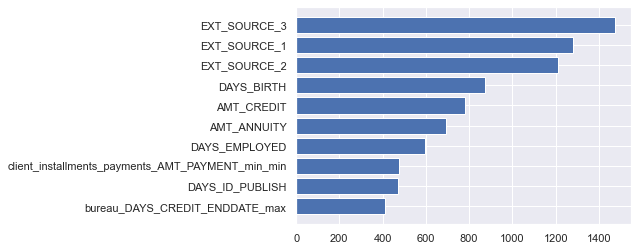

In [147]:
x = feature_importances_top.sort_values('importance')['feature']
y = feature_importances_top.sort_values('importance')['importance']

plt.figure(figsize=(6,4))
plt.barh(x, y)
plt.show()

>Ces informations représentent un premier niveau d’**interprétation** du modèle. Elles indiquent quelles sont, globalement, les variables qui influencent le plus la décision de classification.

#### On retient les principales variables pour réduire les jeux de données destinés à l'export vers l\'application

In [148]:
feat_imp_app = feat_imp.sort_values('importance', ascending=False).head(50)
feat_imp_app.reset_index(drop=True, inplace=True)

# On normalise les valeurs de la variable 'importance'
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
imp_std = min_max_scaler.fit_transform(feat_imp_app[['importance']])
df_imp_std = pd.DataFrame(imp_std)

feat_imp_app = feat_imp_app.merge(df_imp_std, left_index=True, right_index=True)
del feat_imp_app['importance']
feat_imp_app.columns = ['feature','importance']
feat_imp_app['importance'] = round((feat_imp_app['importance']),2)*100
feat_imp_app['importance']=feat_imp_app['importance'].astype('int')
feat_imp_app.head()

feature  importance
0  EXT_SOURCE_3         100
1  EXT_SOURCE_1          85
2  EXT_SOURCE_2          79
3    DAYS_BIRTH          53
4    AMT_CREDIT          46

In [149]:
time_calc('Importance des variables - '+df_app_name,'')
t = time.time()

Durée de l'opération 'Importance des variables - df_app_2': 0.44 s


## Classification report <a class="anchor" id="cla_rep"></a>

In [150]:
from sklearn.metrics import classification_report

kf_list = [1, 2, 3, 4, 5]

for kf in kf_list:
    clf = joblib.load(path_models+df_app_name+'_'+strat_+'_'+lgbm_version_+'_'+str(kf)+'.joblib')
#     test_pred_bin = clf.predict(test_features)
    test_pred_kf = clf.predict_proba(test_features)[:,1]
    test_pred_bin = (test_pred_kf > solvability_threshold_g_norm)
    test_pred_bin = np.array(test_pred_bin > 0) * 1

    print(classification_report(test_labels, test_pred_bin))
    print(55*'-')

              precision    recall  f1-score   support

           0       0.96      0.88      0.92     56521
           1       0.30      0.59      0.39      4982

    accuracy                           0.85     61503
   macro avg       0.63      0.73      0.66     61503
weighted avg       0.91      0.85      0.87     61503

-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.87      0.92     56521
           1       0.30      0.60      0.40      4982

    accuracy                           0.85     61503
   macro avg       0.63      0.74      0.66     61503
weighted avg       0.91      0.85      0.87     61503

-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.87      0.92     56521
           1       0.29      0.60      0.39      4982

    accuracy                           0.85     61503
   macro avg    

**Choix d'un modèle**

In [151]:
from sklearn.metrics import classification_report

kf = 3

model = joblib.load(path_models+df_app_name+'_'+strat_+'_'+lgbm_version_+'_'+str(kf)+'.joblib')
print(path_models+df_app_name+'_'+strat_+'_'+lgbm_version_+'_'+str(kf)+'.joblib')

../OC_DS_P7/models/df_app_2_1_lgbm_3_3.joblib


In [152]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.0207747487935626,
 'max_depth': 18,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 600,
 'n_jobs': -1,
 'num_leaves': 76,
 'objective': 'binary',
 'random_state': 45,
 'reg_alpha': 1.0,
 'reg_lambda': 0.30000000000000004,
 'silent': True,
 'subsample': 0.8,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [153]:
train_pred_bin = model.predict(features)
test_pred_bin = model.predict(test_features)

print(classification_report(test_labels, test_pred_bin))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     56521
           1       0.34      0.51      0.41      4982

    accuracy                           0.88     61503
   macro avg       0.65      0.71      0.67     61503
weighted avg       0.90      0.88      0.89     61503



In [154]:
test_pred_bin = (test_pred > solvability_threshold_g_norm)
test_pred_bin = np.array(test_pred_bin > 0) * 1

print(classification_report(test_labels, test_pred_bin))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92     56521
           1       0.30      0.60      0.40      4982

    accuracy                           0.85     61503
   macro avg       0.63      0.74      0.66     61503
weighted avg       0.91      0.85      0.88     61503



In [155]:
test_pred_bin = (test_pred > solvability_threshold_g_norm_adj)
test_pred_bin = np.array(test_pred_bin > 0) * 1

print(classification_report(test_labels, test_pred_bin))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     56521
           1       0.23      0.72      0.35      4982

    accuracy                           0.79     61503
   macro avg       0.60      0.75      0.61     61503
weighted avg       0.91      0.79      0.83     61503



In [156]:
from sklearn.metrics import precision_recall_fscore_support

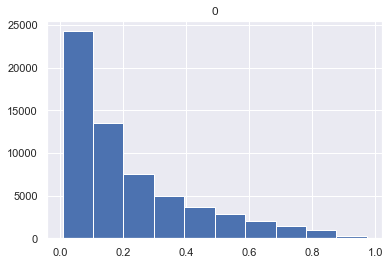

In [157]:
pd.DataFrame(test_pred).hist();

In [158]:
time_calc('Classification report - '+df_app_name,'')
t = time.time()

Durée de l'opération 'Classification report - df_app_2': 25.77 s


## Jeu de test sans étiquettes <a class="anchor" id="jeu_tes_san_eti"></a>

### Récupération des données

In [159]:
# On récupère le jeu de test sans étiquette produit lors de l'analyse
test_sub_features = joblib.load(path_data+'df_app_test_2.joblib')
print('Dimension du jeu de test (sub) initial: ',test_sub_features.shape)

Dimension du jeu de test (sub) initial:  (48744, 1770)


### Identifiants

In [160]:
test_sub_ids_ = test_sub_features['SK_ID_CURR']

### Variables

In [161]:
# On applique les corrections de noms de variables (pour conformité avec lgbm)
import re
test_sub_features = test_sub_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_sub_features.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_sub_features.columns]

# On limite les variables au nombre défini à l'étape de sélection des variables (feat_selec)
test_sub_features = test_sub_features[feat_selec]
print('Dimension du jeu de test (sub) après réduction de dimensions (variables): ',test_sub_features.shape)

# On sauvegarde les variables
joblib.dump(test_sub_features, path_features+'test_sub_features.joblib')

Dimension du jeu de test (sub) après réduction de dimensions (variables):  (48744, 350)


['../OC_DS_P7/features/test_sub_features.joblib']

### Prédictions binaires

On réalise les prédictions binaires sur le jeu de test en faisant la moyenne des résultats obtenus avec chacun des 5 modèles du classifieur.

In [162]:
test_sub_pred = np.zeros(test_sub_features.shape[0])

for kf in range(1,6):
    clf = joblib.load(path_models+df_app_name+'_'+strat_+'_'+lgbm_version_+'_'+str(kf)+'.joblib')
    test_sub_pred += clf.predict_proba(test_sub_features)[:,1] / 5

print(test_sub_pred)

[0.17716652 0.22057102 0.08495751 ... 0.05818051 0.1488706  0.45082402]


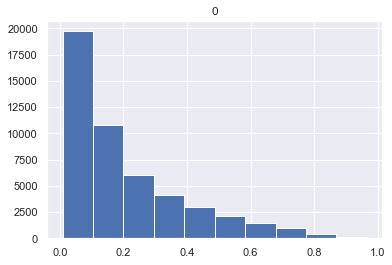

In [163]:
pd.DataFrame(test_sub_pred).hist();

## Interprétation <a class="anchor" id="int_2"></a>

### Interprétation avec LIME <a class="anchor" id="int_lim"></a>

`LIME` (**L**ocal **I**nterpretable **M**odel-Agnostic **E**xplanations) est une bibliothèque Python pour l'interprétabilité locale.

In [164]:
import lime
import lime.lime_tabular

print('df_app_name =',df_app_name)
print('lgbm_version_ =',lgbm_version_)
print('Dimensions du jeu d\'entraînement:',features.shape)
print('Dimensions du jeu de test:',test_features.shape)

df_app_name = df_app_2
lgbm_version_ = lgbm_3
Dimensions du jeu d'entraînement: (271398, 350)
Dimensions du jeu de test: (61503, 350)


On créé un dataframe contenant les variables relatives aux classes (prédictions, valeurs réelles)

In [165]:
# test_ids_ = test_ids
test_res = pd.DataFrame(test_labels).merge(test_features, left_index=True, right_index=True)
test_res = pd.DataFrame(test_ids).merge(test_res, left_index=True, right_index=True)
test_res.reset_index(inplace=True)
test_res = pd.DataFrame(test_pred).merge(test_res, left_index=True, right_index=True)
test_res = pd.DataFrame(test_pred_bin).merge(test_res, left_index=True, right_index=True)
test_res = test_res[['index','SK_ID_CURR','0_y','0_x','TARGET']]
test_res.columns = ['index','SK_ID_CURR','Pred_proba','Pred','TARGET']
test_res.head()

index  SK_ID_CURR  Pred_proba  Pred  TARGET
0  179042      307474    0.052043     0       0
1  269683      412537    0.120762     0       0
2   42405      149084    0.190658     0       0
3  228527      364692    0.414694     1       0
4   47854      155423    0.163292     0       0

In [166]:
solvability_threshold_g_norm_adj

0.3126

In [167]:
test_res[test_res['SK_ID_CURR']==438878]

index  SK_ID_CURR  Pred_proba  Pred  TARGET
50388  292521      438878    0.609992     1       0

In [168]:
 explainer = lime.lime_tabular.LimeTabularExplainer(training_data = test_features.values,
                                                   mode='classification',
                                                   training_labels = test_pred, 
                                                   feature_names = feature_names)

In [169]:
time_calc('Explainer Lime - '+df_app_name)
t = time.time()

Durée de l'opération 'Explainer Lime - df_app_2': 22.34 s


In [170]:
def explanation(i):
    
    exp = explainer.explain_instance(test_features.iloc[i,:].values, model.predict_proba, num_features=10)
    
    # Visualisation des résultats
    exp.show_in_notebook(show_table=True)

In [171]:
# La variable 'credit_id_default' correspond à l'identifiant 'SK_ID_CURR' du premier individu du dataframe test_res
credit_id_default = test_res['SK_ID_CURR'][0]
print('Identifiant du premier individu:',credit_id_default)

Identifiant du premier individu: 307474


In [172]:
# On peut choisir un autre individu en affectant la valeur de son identifiant 'SK_ID_CURR' à la variable 'credit_id'
credit_id = credit_id_default
# credit_id = 363628
print(credit_id)

307474


In [173]:
# On récupère la valeur de l'index de l'individu identifié par 'credit_id'
credit_index = test_res[test_res['SK_ID_CURR'] == credit_id].index[0]
print(credit_index)

0


In [174]:
i = credit_index
explanation(i)

In [175]:
print('Prédiction proba pour l\'individu sélectionné:',round((pd.DataFrame(test_pred).iloc[i,:].values.tolist()[0]),4))
print('Prédiction binaire pour l\'individu sélectionné:',round((pd.DataFrame(test_pred_bin).iloc[i,:].values.tolist()[0]),4))
print('Valeur réelle pour l\'individu sélectionné:',round((pd.DataFrame(test_labels).iloc[i,:].values.tolist()[0]),4))

Prédiction proba pour l'individu sélectionné: 0.052
Prédiction binaire pour l'individu sélectionné: 0
Valeur réelle pour l'individu sélectionné: 0


In [176]:
time_calc('Results Lime - '+df_app_name)
t = time.time()

Durée de l'opération 'Results Lime - df_app_2': 12.81 s


### Interprétation avec SHAP <a class="anchor" id="int_sha"></a>

Nous avons implémenté la méthode `SHAP` (**SH**apley **A**dditive ex**P**lanations) qui consiste à calculer la **valeur de Shapley** pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles.

>La somme des effets de chaque variable explique alors la prédiction.

In [177]:
import shap

In [178]:
S = test_features
S.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
179042             0           67500.0   1030302.0      40860.0   
269683             0           90000.0    253737.0      26775.0   
42405              0          270000.0   1006920.0      45499.5   
228527             2          202500.0    495351.0      29497.5   
47854              0          162000.0    264159.0      13617.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
179042                    0.004960      -19842          -3001   
269683                    0.009175      -16820           -445   
42405                     0.007330      -16078          -1273   
228527                    0.031329      -13434          -4101   
47854                     0.007020      -21702          -4388   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  \
179042            -8588.0            -2278         12.0  ...   
269683            -6378.0             -355         65.0  ...   
42405             -8787.0            -4126          7.0  ...   
228527            -2432.0            -3253         17.0  ...   
47854             -6314.0            -5085         15.0  ...   

        client_credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_mean_sum  \
179042                                           0.000000              
269683                                           0.000000              
42405                                            0.000000              
228527                                           0.000000              
47854                                         3282.352941              

        client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_mean_sum  \
179042                                                0.0              
269683                                                0.0              
42405                                                 0.0              
228527                                                0.0              
47854                                                 0.0              

        client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_min_sum  \
179042                                                0.0             
269683                                                0.0             
42405                                                 0.0             
228527                                                0.0             
47854                                                 0.0             

        client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_sum_mean  \
179042                                                0.0              
269683                                                0.0              
42405                                                 0.0              
228527                                                0.0              
47854                                                 0.0              

        client_credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_mean_sum  \
179042                                           0.000000              
269683                                           0.000000              
42405                                            0.000000              
228527                                           0.000000              
47854                                            0.070588              

        client_credit_card_balance_CNT_DRAWINGS_CURRENT_mean_mean  \
179042                                           0.000000           
269683                                           0.000000           
42405                                            0.000000           
228527                                           0.000000           
47854                                            0.081395           

        client_credit_card_balance_CNT_DRAWINGS_CURRENT_max_mean  \
179042                                                0.0          
269683                                                0.0          
42405                                              

In [179]:
t = time.time()

In [180]:
shap_ = r_

print('shap_ =',shap_)
print('df_app_name =',df_app_name)
print('lgbm_version_ =',lgbm_version_)

shap_ = 0
df_app_name = df_app_2
lgbm_version_ = lgbm_3


In [181]:
#####################
### Shap test_sub ###
#####################

if shap_ == 1:
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(test_sub_features)

    joblib.dump(explainerModel, '../OC_DS_P7/interpretation/'+df_app_name+'_explainerModel_sub.joblib')
    joblib.dump(shap_values_Model, '../OC_DS_P7/interpretation/'+df_app_name+'_shap_values_Model_sub.joblib')

In [182]:
time_calc('Explainer Shap - df_app_test_2','925')
t = time.time()

Durée de l'opération 'Explainer Shap - df_app_test_2': 0.04 s


In [183]:
if shap_ == 1:
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    joblib.dump(explainerModel, '../OC_DS_P7/interpretation/'+df_app_name+'_explainerModel.joblib')
    joblib.dump(shap_values_Model, '../OC_DS_P7/interpretation/'+df_app_name+'_shap_values_Model.joblib')
    
if shap_ == 0:
    explainerModel = joblib.load('../OC_DS_P7/interpretation/'+df_app_name+'_explainerModel.joblib')
    shap_values_Model = joblib.load('../OC_DS_P7/interpretation/'+df_app_name+'_shap_values_Model.joblib')

In [184]:
# Initialisation du notebook avec initjs()
shap.initjs()

Le graphe ci-dessous représente les impacts des valeurs des variables importantes sur la prédiction.

Les variables en rouge contribuent le plus à une prédiction positive (dossier non remboursé), les variables en bleu contribuent le plus à une prédiction négative (dossier remboursé).

In [185]:
j = credit_index
print('credit_index =',j)
shap.force_plot(explainerModel.expected_value[1], shap_values_Model[1][j], S.iloc[[j]])

credit_index = 0


*Dans cet exemple, la valeur SHAP est inférieure à la valeur de base, le dossier est classé négatif. Les variables en bleu expliquent cette décision.*

In [186]:
time_calc('Explainer Shap - '+df_app_name,'1172')
t = time.time()

Durée de l'opération 'Explainer Shap - df_app_2': 1.44 s


In [187]:
shap_values = shap_values_Model

`SHAP` permet également une analyse **globale**.

En effet, en moyennant les valeurs absolues des valeurs de chaque variable (niveau local), on remonte à l’importance globale des variables.

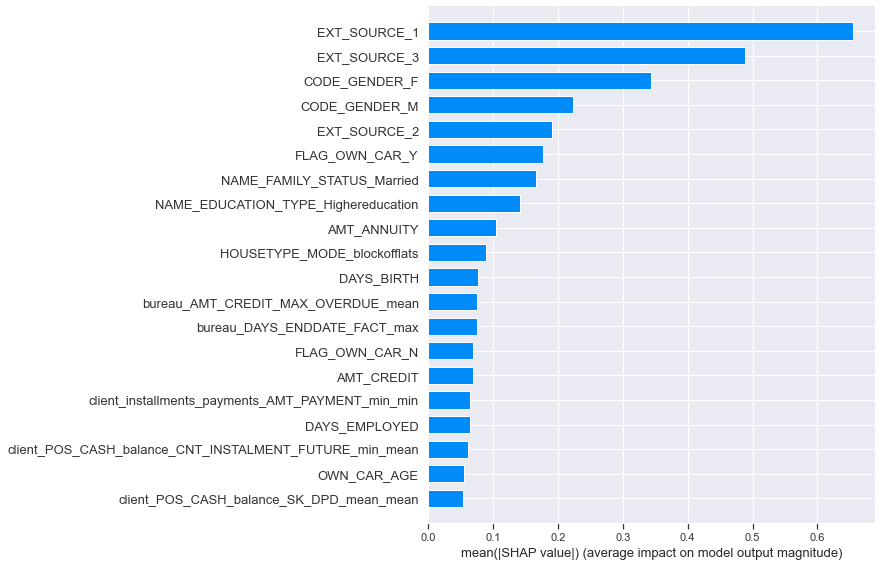

In [188]:
shap.summary_plot(shap_values[0], S, plot_type='bar')
# Avec l'ensemble des classes
# shap.summary_plot(shap_values, S, plot_type='bar')

Dans le graphe ci-dessous, les dossiers sont représentés par des points dont la couleur varie en fonction de la valeur de la variable (petite à grande valeur = bleu à rouge).

Les points sont positionnés sur l’axe des abscisses selon leur valeur SHAP ce qui caractérise l’impact de la variable sur la prédiction.

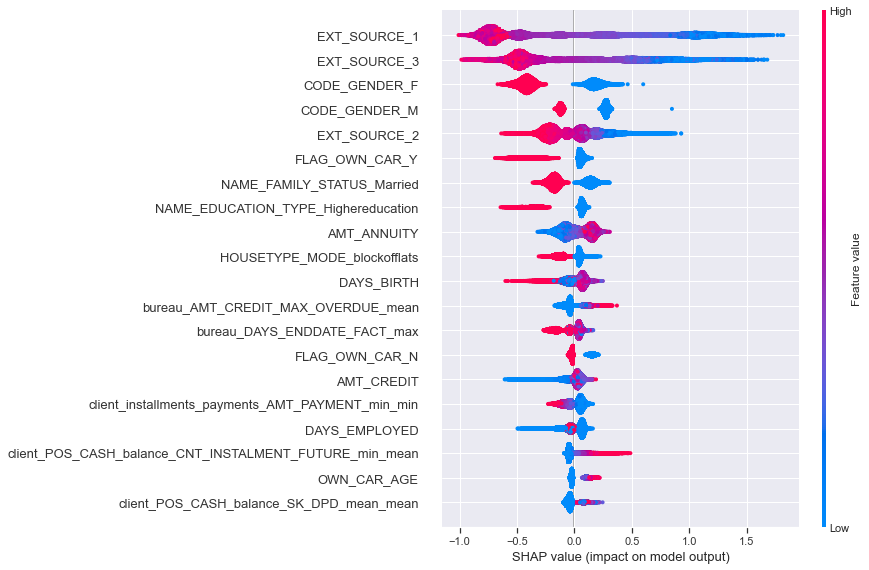

In [189]:
# import matplotlib.pyplot as plt
shap.summary_plot(shap_values[1], S, show=False)
# plt.savefig('shap_summary_plot.png')

*Le fait d’être une femme présente globalement un impact négatif sur la valeur SHAP ce qui contribue à ce que la prédiction soit plus basse que la valeur de base (ce qui caractérise les dossiers négatifs).*

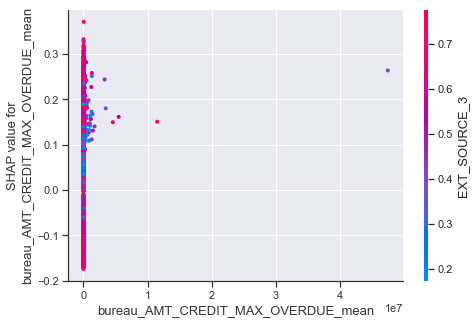

In [190]:
# shap.dependence_plot('CODE_GENDER_F', shap_values[1], S)
# shap.dependence_plot('FLAG_OWN_CAR_Y', shap_values[1], S)
# shap.dependence_plot('DAYS_EMPLOYED', shap_values[1], S)
shap.dependence_plot('bureau_AMT_CREDIT_MAX_OVERDUE_mean', shap_values[1], S)

In [191]:
time_calc('Plots Shap - '+df_app_name,'',1)
t = time.time()

Durée de l'opération 'Plots Shap - df_app_2': 26.31 s
Durée totale de traitement: 00 h 03 m 13 s


### Fonction LIME / SHAP

La fonction **expla()** prend en entrée l'identifiant d'un dossier et retourne les graphes `SHAP` et `Lime` (option) d'interprétabilité locale.

In [192]:
def expla(credit_id=credit_id_default,lime_=0):
    
    i = test_res[test_res['SK_ID_CURR'] == credit_id].index[0]
    print('Dossier de crédit =',credit_id)
    
    print('Prédiction proba pour l\'individu sélectionné:',round((pd.DataFrame(test_pred).iloc[i,:].values.tolist()[0]),4))
    print('Prédiction binaire pour l\'individu sélectionné:',round((pd.DataFrame(test_pred_bin).iloc[i,:].values.tolist()[0]),4))
    print('Valeur réelle pour l\'individu sélectionné:',round((pd.DataFrame(test_labels).iloc[i,:].values.tolist()[0]),4))
    
    # Lime
    if lime_ == 1:
        explanation(i)

    # Shap
    S = test_features
    return shap.force_plot(explainerModel.expected_value[1], shap_values_Model[1][i], S.iloc[[i]])

Dans l'exemple suivant, l'individu présente une prédiction **inférieure** au seuil, il est donc classé **négatif (0)**.
>La valeur Shap est donc **inférieure** à la valeur de base.

In [193]:
expla()

Dossier de crédit = 307474
Prédiction proba pour l'individu sélectionné: 0.052
Prédiction binaire pour l'individu sélectionné: 0
Valeur réelle pour l'individu sélectionné: 0


Dans l'exemple suivant, l'individu présente une prédiction très **supérieure** au seuil, il est donc classé **positif (1)**.
>La valeur Shap est donc très **supérieure** à la valeur de base.

In [194]:
expla(402778)

Dossier de crédit = 402778
Prédiction proba pour l'individu sélectionné: 0.6221
Prédiction binaire pour l'individu sélectionné: 1
Valeur réelle pour l'individu sélectionné: 1


In [195]:
expla(110244,1)

Dossier de crédit = 110244
Prédiction proba pour l'individu sélectionné: 0.4523
Prédiction binaire pour l'individu sélectionné: 1
Valeur réelle pour l'individu sélectionné: 0


In [196]:
expla(422949,1)

Dossier de crédit = 422949
Prédiction proba pour l'individu sélectionné: 0.356
Prédiction binaire pour l'individu sélectionné: 1
Valeur réelle pour l'individu sélectionné: 0


In [197]:
expla(182049,1)

Dossier de crédit = 182049
Prédiction proba pour l'individu sélectionné: 0.284
Prédiction binaire pour l'individu sélectionné: 0
Valeur réelle pour l'individu sélectionné: 0


In [198]:
expla(136687)

Dossier de crédit = 136687
Prédiction proba pour l'individu sélectionné: 0.6548
Prédiction binaire pour l'individu sélectionné: 1
Valeur réelle pour l'individu sélectionné: 0


In [199]:
col_desc('','NAME_EDUCATION_TYPE')

[['application_{train|test}.csv' 'NAME_EDUCATION_TYPE'
  'Level of highest education the client achieved ']]


In [200]:
col_desc('','CODE_GENDER')

[['application_{train|test}.csv' 'CODE_GENDER' 'Gender of the client ']]


In [201]:
col_desc('','DAYS_EMP')

[['application_{train|test}.csv' 'DAYS_EMPLOYED'
  'How many days before the application the person started current employment (time only relative to the application)']]


In [202]:
col_desc('','AMT_CREDIT')

[['application_{train|test}.csv' 'AMT_CREDIT'
  'Credit amount of the loan ']
 ['bureau.csv' 'AMT_CREDIT_MAX_OVERDUE'
  'Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample) ']
 ['bureau.csv' 'AMT_CREDIT_SUM'
  'Current credit amount for the Credit Bureau credit ']
 ['bureau.csv' 'AMT_CREDIT_SUM_DEBT'
  'Current debt on Credit Bureau credit ']
 ['bureau.csv' 'AMT_CREDIT_SUM_LIMIT'
  'Current credit limit of credit card reported in Credit Bureau ']
 ['bureau.csv' 'AMT_CREDIT_SUM_OVERDUE'
  'Current amount overdue on Credit Bureau credit ']
 ['credit_card_balance.csv' 'AMT_CREDIT_LIMIT_ACTUAL'
  'Credit card limit during the month of the previous credit ']
 ['previous_application.csv' 'AMT_CREDIT'
  'Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amo

## Application Dash <a class="anchor" id="app_das"></a>

In [203]:
# 50 variables les plus importantes
feat_imp_app.head()

feature  importance
0  EXT_SOURCE_3         100
1  EXT_SOURCE_1          85
2  EXT_SOURCE_2          79
3    DAYS_BIRTH          53
4    AMT_CREDIT          46

In [204]:
# On limite le nombre de variables des jeux de test aux variables les plus importantes
feature_names_app = feat_imp_app['feature']

test_features_app = test_features[feature_names_app]
print(test_features_app.shape)

test_sub_features_app = test_sub_features[feature_names_app]
print(test_sub_features_app.shape)

(61503, 50)
(48744, 50)


### Similarité <a class="anchor" id="sim"></a>

Nous utilisons ici la méthode des plus proches voisins pour identifier des similarités entre individus.

Cette fonctionnalité sera utile dans l'application pour la comparaison de dossiers similaires.

In [205]:
from sklearn.neighbors import NearestNeighbors

In [206]:
test_features.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
179042             0           67500.0   1030302.0      40860.0   
269683             0           90000.0    253737.0      26775.0   
42405              0          270000.0   1006920.0      45499.5   
228527             2          202500.0    495351.0      29497.5   
47854              0          162000.0    264159.0      13617.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
179042                    0.004960      -19842          -3001   
269683                    0.009175      -16820           -445   
42405                     0.007330      -16078          -1273   
228527                    0.031329      -13434          -4101   
47854                     0.007020      -21702          -4388   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  \
179042            -8588.0            -2278         12.0  ...   
269683            -6378.0             -355         65.0  ...   
42405             -8787.0            -4126          7.0  ...   
228527            -2432.0            -3253         17.0  ...   
47854             -6314.0            -5085         15.0  ...   

        client_credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_mean_sum  \
179042                                           0.000000              
269683                                           0.000000              
42405                                            0.000000              
228527                                           0.000000              
47854                                         3282.352941              

        client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_mean_sum  \
179042                                                0.0              
269683                                                0.0              
42405                                                 0.0              
228527                                                0.0              
47854                                                 0.0              

        client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_min_sum  \
179042                                                0.0             
269683                                                0.0             
42405                                                 0.0             
228527                                                0.0             
47854                                                 0.0             

        client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_sum_mean  \
179042                                                0.0              
269683                                                0.0              
42405                                                 0.0              
228527                                                0.0              
47854                                                 0.0              

        client_credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_mean_sum  \
179042                                           0.000000              
269683                                           0.000000              
42405                                            0.000000              
228527                                           0.000000              
47854                                            0.070588              

        client_credit_card_balance_CNT_DRAWINGS_CURRENT_mean_mean  \
179042                                           0.000000           
269683                                           0.000000           
42405                                            0.000000           
228527                                           0.000000           
47854                                            0.081395           

        client_credit_card_balance_CNT_DRAWINGS_CURRENT_max_mean  \
179042                                                0.0          
269683                                                0.0          
42405                                              

In [207]:
test_sub_features.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0             0          135000.0    568800.0      20560.5   
1             0           99000.0    222768.0      17370.0   
2             0          202500.0    663264.0      69777.0   
3             2          315000.0   1575000.0      49018.5   
4             1          180000.0    625500.0      32067.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018850      -19241          -2329            -5170.0   
1                    0.035792      -18064          -4469            -9118.0   
2                    0.019101      -20038          -4458            -2175.0   
3                    0.026392      -13976          -1866            -2000.0   
4                    0.010032      -13040          -2191            -4000.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  \
0             -812          NaN  ...   
1            -1623          NaN  ...   
2            -3503          5.0  ...   
3            -4208          NaN  ...   
4            -4262         16.0  ...   

   client_credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_mean_sum  \
0                                           0.000000              
1                                           0.000000              
2                                           0.000000              
3                                         613.636364              
4                                           0.000000              

   client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_mean_sum  \
0                                              0.000              
1                                              0.000              
2                                              0.000              
3                                           6242.355              
4                                              0.000              

   client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_min_sum  \
0                                                0.0             
1                                                0.0             
2                                                0.0             
3                                                0.0             
4                                                0.0             

   client_credit_card_balance_AMT_DRAWINGS_POS_CURRENT_sum_mean  \
0                                                NaN              
1                                                NaN              
2                                                NaN              
3                                          274663.62              
4                                                NaN              

   client_credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_mean_sum  \
0                                           0.000000              
1                                           0.000000              
2                                           0.000000              
3                                           0.045455              
4                                           0.000000              

   client_credit_card_balance_CNT_DRAWINGS_CURRENT_mean_mean  \
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                           2.387755           
4                                                NaN           

   client_credit_card_balance_CNT_DRAWINGS_CURRENT_max_mean  EXT_SOURCE_1  \
0                                                NaN             0.752614   
1                                                NaN             0.564990   
2                                                NaN             0.472158   
3                                               12.0             0.525734   
4                                                NaN             0.202145   

   EXT_SOURCE_2  EXT_SOURCE_3  
0      0.789654      0.15

In [208]:
test_features_app.head()

EXT_SOURCE_3  EXT_SOURCE_1  EXT_SOURCE_2  DAYS_BIRTH  AMT_CREDIT  \
179042      0.612704      0.835209      0.515916      -19842   1030302.0   
269683      0.712155      0.420288      0.730601      -16820    253737.0   
42405       0.522697      0.373953      0.580192      -16078   1006920.0   
228527      0.453113      0.393321      0.555680      -13434    495351.0   
47854       0.554947      0.472005      0.035745      -21702    264159.0   

        AMT_ANNUITY  DAYS_EMPLOYED  \
179042      40860.0          -3001   
269683      26775.0           -445   
42405       45499.5          -1273   
228527      29497.5          -4101   
47854       13617.0          -4388   

        client_installments_payments_AMT_PAYMENT_min_min  DAYS_ID_PUBLISH  \
179042                                          6742.305            -2278   
269683                                           276.615             -355   
42405                                           5447.790            -4126   
228527                                          9564.705            -3253   
47854                                             75.465            -5085   

        bureau_DAYS_CREDIT_ENDDATE_max  ...  bureau_DAYS_CREDIT_ENDDATE_sum  \
179042                            51.0  ...                         -1742.0   
269683                         27375.0  ...                         22547.0   
42405                           -457.0  ...                          -457.0   
228527                             0.0  ...                             0.0   
47854                           1449.0  ...                         -1257.0   

        previous_application_SELLERPLACE_AREA_mean  \
179042                                  286.000000   
269683                                   32.500000   
42405                                    39.333333   
228527                                    7.428571   
47854                                   644.000000   

        previous_application_HOUR_APPR_PROCESS_START_mean  \
179042                                          15.000000   
269683                                          10.000000   
42405                                           16.333333   
228527                                          12.714286   
47854                                           12.400000   

        bureau_DAYS_CREDIT_mean  OBS_30_CNT_SOCIAL_CIRCLE  \
179042                  -908.60                       1.0   
269683                 -1584.75                       2.0   
42405                  -1553.00                       0.0   
228527                     0.00                       2.0   
47854                  -1321.40                       3.0   

        bureau_DAYS_CREDIT_min  previous_application_DAYS_DECISION_max  \
179042                 -2203.0                                   -19.0   
269683                 -2035.0                                  -172.0   
42405                  -1553.0                                 -1242.0   
228527                     0.0                                  -408.0   
47854                  -2870.0                                  -364.0   

        client_installments_payments_DAYS_INSTALMENT_sum_max  \
179042                                             -516.0      
269683                                            -4632.0      
42405                                            -12564.0      
228527                                            -2420.0      
47854                                             -2028.0      

        bureau_CREDIT_ACTIVE_Closed_count_norm  \
179042                                    1.00   
269683                                    0.75   
42405                                     1.00   
228527                                    0.00   
47854                                     0.60   

        client_installments_payments_AMT_INSTALMENT_min_mean  
179042                                         6742.30500     
269683                                         7850.29500     
42405

In [209]:
test_sub_features_app.head()

EXT_SOURCE_3  EXT_SOURCE_1  EXT_SOURCE_2  DAYS_BIRTH  AMT_CREDIT  \
0      0.159520      0.752614      0.789654      -19241    568800.0   
1      0.432962      0.564990      0.291656      -18064    222768.0   
2      0.610991      0.472158      0.699787      -20038    663264.0   
3      0.612704      0.525734      0.509677      -13976   1575000.0   
4      0.422334      0.202145      0.425687      -13040    625500.0   

   AMT_ANNUITY  DAYS_EMPLOYED  \
0      20560.5          -2329   
1      17370.0          -4469   
2      69777.0          -4458   
3      49018.5          -1866   
4      32067.0          -2191   

   client_installments_payments_AMT_PAYMENT_min_min  DAYS_ID_PUBLISH  \
0                                          3951.000             -812   
1                                          4813.200            -1623   
2                                             6.165            -3503   
3                                             1.170            -4208   
4                                         11097.450            -4262   

   bureau_DAYS_CREDIT_ENDDATE_max  ...  bureau_DAYS_CREDIT_ENDDATE_sum  \
0                          1778.0  ...                           577.0   
1                          1324.0  ...                          1318.0   
2                          -567.0  ...                         -4272.0   
3                         30885.0  ...                         23877.0   
4                             NaN  ...                             NaN   

   previous_application_SELLERPLACE_AREA_mean  \
0                                        23.0   
1                                        18.0   
2                                        82.0   
3                                      1409.6   
4                                        13.0   

   previous_application_HOUR_APPR_PROCESS_START_mean  bureau_DAYS_CREDIT_mean  \
0                                               13.0              -735.000000   
1                                               10.5              -190.666667   
2                                               14.5             -1737.500000   
3                                               10.8             -1401.750000   
4                                                5.5                      NaN   

   OBS_30_CNT_SOCIAL_CIRCLE  bureau_DAYS_CREDIT_min  \
0                       0.0                 -1572.0   
1                       0.0                  -373.0   
2                       0.0                 -2070.0   
3                       0.0                 -2105.0   
4                       0.0                     NaN   

   previous_application_DAYS_DECISION_max  \
0                                 -1740.0   
1                                  -315.0   
2                                  -222.0   
3                                  -531.0   
4                                  -111.0   

   client_installments_payments_DAYS_INSTALMENT_sum_max  \
0                                            -6656.0      
1                                            -5274.0      
2                                            -1276.0      
3                                            -3530.0      
4                                            -7464.0      

   bureau_CREDIT_ACTIVE_Closed_count_norm  \
0                                0.571429   
1                                0.333333   
2                                1.000000   
3                                0.583333   
4                                     NaN   

   client_installments_payments_AMT_INSTALMENT_min_mean  
0                                           3951.000     
1                                           4813.200     
2                                          11477.805     
3                                           4234.890     
4                                          11097.450     

[5 rows x 50 columns]

In [210]:
test_features_ = test_features_app
test_sub_features_ = test_sub_features_app

In [211]:
nn_credit_test = NearestNeighbors(n_neighbors=10, radius=0.4)
nn_credit_test.fit(test_features_)

NearestNeighbors(n_neighbors=10, radius=0.4)

In [212]:
test_sub_features_.isna().sum().sum()

192472

In [213]:
test_sub_features_ = test_sub_features_.fillna(0)

In [214]:
test_sub_features_.isna().sum().sum()

0

In [215]:
nn_credit_test_sub = NearestNeighbors(n_neighbors=10, radius=0.4)
nn_credit_test_sub.fit(test_sub_features_)

NearestNeighbors(n_neighbors=10, radius=0.4)

In [216]:
cid = 100
credit = test_features_.iloc[cid:cid+1,:]
credit

EXT_SOURCE_3  EXT_SOURCE_1  EXT_SOURCE_2  DAYS_BIRTH  AMT_CREDIT  \
245506      0.521268        0.5771      0.534884      -15701    288994.5   

        AMT_ANNUITY  DAYS_EMPLOYED  \
245506      30793.5          -4014   

        client_installments_payments_AMT_PAYMENT_min_min  DAYS_ID_PUBLISH  \
245506                                           165.555            -3754   

        bureau_DAYS_CREDIT_ENDDATE_max  ...  bureau_DAYS_CREDIT_ENDDATE_sum  \
245506                             0.0  ...                             0.0   

        previous_application_SELLERPLACE_AREA_mean  \
245506                                        -1.0   

        previous_application_HOUR_APPR_PROCESS_START_mean  \
245506                                          11.727273   

        bureau_DAYS_CREDIT_mean  OBS_30_CNT_SOCIAL_CIRCLE  \
245506                      0.0                       0.0   

        bureau_DAYS_CREDIT_min  previous_application_DAYS_DECISION_max  \
245506                     0.0                                  -107.0   

        client_installments_payments_DAYS_INSTALMENT_sum_max  \
245506                                            -8641.0      

        bureau_CREDIT_ACTIVE_Closed_count_norm  \
245506                                     0.0   

        client_installments_payments_AMT_INSTALMENT_min_mean  
245506                                           9736.575     

[1 rows x 50 columns]

In [217]:
nn_credit_test.kneighbors(credit, 15, return_distance=False)

array([[  100, 50040, 14467, 54409, 52343, 40638, 39028, 54163, 59883,
        17142, 16043,  8649, 33545, 58511, 25250]], dtype=int64)

In [218]:
nbrs = nn_credit_test.radius_neighbors(credit, 0.4, return_distance=False)
np.asarray(nbrs[0][0])

array(100, dtype=int64)

### Sérialisation pour l'application Dash <a class="anchor" id="ser_app_das"></a>

On sauvegarde les données spécifiques pour les besoins de l'application Dash.

#### Jeux de données spécifiques

In [219]:
joblib.dump(feature_names, '../OC_DS_P7/features_app/feature_names.joblib')
joblib.dump(test_features_app, '../OC_DS_P7/features_app/test_features.joblib')
joblib.dump(test_sub_features_app, '../OC_DS_P7/features_app/test_sub_features.joblib')
joblib.dump(test_ids, '../OC_DS_P7/features_app/test_ids.joblib')
joblib.dump(test_sub_ids_, '../OC_DS_P7/features_app/test_sub_ids.joblib')
joblib.dump(test_pred, '../OC_DS_P7/features_app/test_pred.joblib')
joblib.dump(test_sub_pred, '../OC_DS_P7/features_app/test_sub_pred.joblib')
joblib.dump(test_labels, '../OC_DS_P7/features_app/test_labels.joblib')

['../OC_DS_P7/features_app/test_labels.joblib']

#### Seuil de classification

In [220]:
joblib.dump(solvability_threshold_g_norm, '../OC_DS_P7/results_app/thr_g_norm.joblib')

['../OC_DS_P7/results_app/thr_g_norm.joblib']

#### Dataframe de l'évolution du gain

In [221]:
joblib.dump(df_g_norm_test, '../OC_DS_P7/results_app/df_g_norm.joblib')

['../OC_DS_P7/results_app/df_g_norm.joblib']

#### Modèles des plus proches voisins

In [222]:
joblib.dump(nn_credit_test, '../OC_DS_P7/results_app/nn_credit_test.joblib')
joblib.dump(nn_credit_test_sub, '../OC_DS_P7/results_app/nn_credit_test_sub.joblib')

['../OC_DS_P7/results_app/nn_credit_test_sub.joblib']

#### Variables importantes

In [223]:
joblib.dump(feat_imp_app, '../OC_DS_P7/results_app/feat_imp.joblib')

['../OC_DS_P7/results_app/feat_imp.joblib']

## Synthèse et conclusion <a class="anchor" id="syn_con"></a>

Le projet a été mené en trois principales étapes:

**1)** Analyse et traitement des données

**2)** Modélisation Machine Learning

**3)** Application web

### Analyse

Au cours de l'étape d'analyse, nous avons regroupé et agrégé de nombreuses variables à partir des tables de données à disposition afin d'obtenir un dataframe comprenant l'ensemble des informations, sans préjuger de leur utilité. Nous avons également encodé les variables catégorielles (ce qui augmente également le nombre de variables).

>Nous avons obtenu un dataframe avec **1770** variables (sans la variable cible).

Cela fait beaucoup de variables mais à ce stade il n'est pas évident de savoir lesquelles seront le plus ou le moins utiles.

Par contre, certaines caractéristiques révèlent de manière assez évidente le peu d'intérêt de certaines variables, en particulier:
+ Les variables qui présentent beaucoup de valeurs manquantes
+ Les variables fortement corrélées entre elles
+ Les variables avec une faible variance

Nous avons alors écarté les variables qui présentent ces caractéristiques en appliquant néanmoins des seuils peu restrictifs (valeurs manquantes > 80%, corrélations supérieures à 95%, variance = 0) afin de minimiser le risque de supprimer des variables importantes.

>Ces critères ont néanmoins permis de réduire le nombre de variables à **897**.

Nous avons ensuite constaté que le jeu de données contenait une grande majorité d'échantillons avec des étiquettes négatives (0), donc des dossiers de crédits remboursés. Cela correspond bien à la réalité, les organismes prêteurs mettent tout en oeuvre pour éviter de gérer des dossiers qui risquent le défaut de paiement, cette classe de dossiers est donc naturellement toujours plus petite que la classe des dossiers de crédits remboursés.

En Machine Learning, la sur-représentation d'individus d'une classe peut poser des problèmes en particulier lorsque l'algorithme de classification se base sur l'exactitude (accuracy) pour construire son modèle, le risque étant la prédiction systématique de la classe dominante.

>Nous avons alors réalisé un traitement de sur-échantillonnage de la classe minoritaire et doublé le ratio (**16.7%** au lieu de **8.07%**).

L’équilibrage des données introduit cependant des données artificielles donc la possibilité d’incohérences.

### Modélisation

Nous sommes face à un problème de classification binaire. L'efficacité d'un classifieur binaire s'évalue idéalement avec la mesure **ROC** (Receiver Operating Characteristic) qui décrit la **sensibilité** (capacité du modèle à détecter les dossiers de crédit non remboursés) et la **spécificité** (capacité du modèle à détecter les dossiers de crédit remboursés).  
L'efficacité d'un modèle est alors fonction de la mesure **AUC** (Area Under the Curve) qui représente l'aire sous la **courbe ROC**.

Nous avons alors entraîné différents type de classifieurs avec comme objectif la maximisation de la valeur **AUC**. Les meilleurs résultats ont été obtenus avec les algorithmes de type *gradient boosting* (`XGBoost`, `CatBoost`, `LightGBM`).

>Nous avons retenu comme modèle de base `LightGBM` car il est de loin le ***plus rapide*** et affiche un **AUC** de **0.833** (un peu moins bon que `XGBoost` avec un **AUC** de **0.834**).

Nous avons alors appliqué une nouvelle réduction de dimensions avec `RFECF` et réduit le nombre de variables à **350**.

>L'entraînement de `LightGBM` sur le nouveau jeu de données a conduit à des performances équivalentes avec un **AUC** de **0.833** (`RFECF` a donc bien joué son rôle).

Jusqu'ici, nous avons utilisé les classifieurs avec leurs hyper-paramètres par défaut.

>L'optimisation des hyper-paramètres de `LightGBM` avec `Hyperopt` a permis d'augmenter la performance du classifieur avec des valeurs **AUC** de **0.836** avec les critères d'évaluation **AUC** et **F1-Score**.

Néanmoins, les critères d'optimisation techniques ne sont pas nécessairement idéaux pour le domaine d'activité. En effet, pour les organismes prêteurs, un crédit non remboursé coûte plus cher qu'un dossier de crédit non signé.

Il s'agit de trouver le meilleur compromis entre le nombre de crédit qu'on accorde mais qui ne seront in fine pas remboursés (les faux négatifs) et le nombre de crédit qu'on refuse et dont on perd potentiellement le bénéfice sur les intérêts pour les clients solvables (les faux positifs).

Nous avons alors soumis au classifieur une fonction de coût adaptée au métier qui se traduit par la maximisation du gain.

>Le modèle final est donc un classifieur `LightGBM` entraîné sur un jeu de **271398 échantillons** dont **16.7%** de classe minoritaire (dossiers négatifs) avec **350 variables**. La mesure de performance **AUC** est de **0.837** et le **gain normalisé** optimal est **0.76**.

### Application

L'analyse et la modélisation ont été réalisées en Python, avec des notebooks Jupyter pour mieux commenter et illustrer la démarche et les résultats.

Afin de mieux communiquer les résultats aux futurs utilisateurs, nous avons développé un prototype d'application web avec la librairie `Dash` en utilisant uniquement le langage Python ce qui a largement facilité la conception.

Le code de l'application est inscrit dans le notebook https://github.com/leerik/OC_DS_P7/blob/master/P7_03_dashboard.ipynb.  
L'application a été déployée via **Heroku** (https://credit-scoring-dashboard.herokuapp.com/).

Elle comprend les principales fonctionnalités suivantes:

+ Choix d'un dossier de crédit à partir d'une liste déroulante

+ Affichage du score du dossier sur un graphique de type *jauge* pour faciliter la lisibilité (le score du dossier est dans la zone verte: le dossier est négatif; il est dans la zone rouge: le dossier est positif)

+ Indication de l'écart du score avec le seuil de classification optimal

+ Affichage de la courbe ROC et de la mesure AUC propres au classifieur avec mise en évidence de la sensibilité et de l'anti-spécificité en fonction du seuil (le seuil peut être ajusté avec un slider, les indicateurs se mettent à jour automatiquement)

+ Affichage des valeurs des indicateurs suivants (également représentés sur un graphique de type *radar*): Sensibilité, Spécificité, F1-Score, Précision, Gain

+ Représentation des ratios positifs et négatifs des prédictions (via des graphes en secteur)

+ Affichage de l'évolution du gain en fonction du seuil (le gain peut être ajusté avec un slider, le graphique met à jour les valeurs des seuils min et max)

+ Affichage des matrices de confusion (valeurs mises à jour automatiquement en fonction des valeurs de seuil et de gain sélectionnées)

+ L'application peut être utilisée avec la base de test ou la base de dossiers à soumettre

+ Tableau des valeurs des principales variables relatives au dossier sélectionné (avec fonctions de filtrage, tri...)

+ Possibilité d'afficher des dossiers similaires selon un critère de similarité (similarité de score ou de variables) pour analyse comparative

+ Affichage du graphe *force_plot* de SHAP montrant les variables ayant influencé la décision pour le dossier concerné et un dossier de référence

+ ...

### Conclusion

Comme nous l'avons mentionné en introduction, les application de **Crédit Scoring**, bien que très répandues, ne sont pas nécessairement bien perçues, en particulier du côté du demandeur de crédit. Le manque de confiance en l'outil peut également se faire sentir au niveau du préteur. Les deux parties ont de forts intérêts dans la négociation.

Un modèle construit avec des technologies de **Machine Learning** apporte une dose supplémentaire de méfiance, de par se réputation de boîte noire.

Notre démarche a consisté à être le plus objectif et transparent possible à chaque étape. Nous ne sommes pas maîtres des processus de décision des classifieurs, par contre nous avons de nombreuses possibilités d'ajuster le modèle global (données d'entrée et hyper-paramètres) et surtout d'en évaluer la performance et la pertinence. Nous avons donc testé différentes méthodes de traitements des données (équilibrage des classes, réduction de dimensions...) et différents classifieurs en procédant systématiquement à des validations croisées.

La compréhension des principes de base utilisés pour construire le modèle améliore nécessairement la confiance de l'utilisateur, du moins celle du prêteur. C'est pourquoi nous avons déployé, dans l'application web, certains résultats dans leur forme mathématique, comme le **courbe ROC** et la **courbe du Gain**. En faisant varier les valeurs de seuil ou de gain, la mise à jour des matrices de confusion et des valeurs des indicateurs permettent au prêteur de simuler diverses situations et de percevoir les impacts.

Le demandeur attend, pour sa part, des éléments plus proches de ses préoccupations, en particulier si sa demande est refusée, il souhaite savoir pourquoi. Entrent alors en jeu les fonctionnalités d'**interprétabilité globale** avec les valeurs des variables ayant le plus d'importance sur les décisions. Avec **LIME** et **SHAP**, on accède à l'**interprétabilité locale**, le prêteur peut facilement voir et comprendre les variables qui ont influencé la décision relative à un dossier particulier.

>Les évolutions technologiques comme **SHAP** et les techniques d'identification des variables importantes apportent beaucoup à l'amélioration de la confiance envers le **Machine Learning** et montrent ici leur intérêt pour le **Crédit Scoring**.

Etant dans une phase de prototypage, les techniques d'interprétabilité doivent également servir à optimiser le modèle. En effet, la mise à disposition de l'application avec ses modules interactifs à des experts *métier* doit leur permettre d'analyser et de valider facilement la pertinence des résultats et de relever les incohérences et ainsi d'aider le Data Scientist à optimiser le modèle.

In [224]:
time_calc('Sérialisation pour l\'application Dash - '+df_app_name,'580',1,1)
t = time.time()

Durée de l'opération "Sérialisation pour l'application Dash - df_app_2": 46.54 s
Durée totale de traitement: 00 h 04 m 00 s

Durée des opérations
--------------------
                                           Opération  Durée Estimation
0                Récupération des données - df_app_2  10.35           
1                       Seuil de variance - df_app_2   2.01           
2          Jeux d'entraînement et de test - df_app_2   3.96           
3             Sans traitement des données - df_app_2  19.92           
4               Sur-échantillonnage Smote - df_app_2  10.58        145
5           Sous-échantillonnage NearMiss - df_app_2   7.45       1286
6         Sous-échantillonnage TomekLinks - df_app_2   9.45       2933
7                  Traitement des données - df_app_2   2.05           
8           Modélisation Machine Learning - df_app_2   0.55           
9           Entraînement des classifieurs - df_app_2   1.60      21260
10               Importance des variables - df_app_2